**Author**: Abhinav, Adit, Aditi & Aditya

In [5]:
!python --version

Python 3.11.5


In [6]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [7]:
import findspark
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, Row, DataFrame as pysparkDF
from pyspark.sql.types import FloatType, StringType, IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array, array_to_vector
from pyspark.ml.feature import StandardScaler, StringIndexer,\
    Bucketizer, QuantileDiscretizer, Imputer, OneHotEncoder, PCA,\
    VectorAssembler, VectorSlicer, UnivariateFeatureSelector
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.clustering import BisectingKMeans, KMeans, GaussianMixture
from pyspark.ml.classification import LinearSVC, LogisticRegression,\
    RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import ClusteringEvaluator,\
    BinaryClassificationEvaluator
from matplotlib import pyplot as plt, ticker as mtick
from itertools import accumulate

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
findspark.init()
spark = (
    SparkSession
    .builder
    .appName("DDAM_project")
    .master("local[*]")
    .config("spark.driver.memory", "8g")
    # .config("spark.driver.host", "localhost")
    .getOrCreate()
)
sc = spark.sparkContext

In [10]:
spark

---

# Methodology

The dataset is sizable but not enormous. However, I made an effort to mimic a big data environment. I utilized pandas when I needed to display a variety of short dataframes or series, such as summary tables, and I used PySpark in a distributed fashion in all other situations. For visualisation tasks requiring a large amount of data, a sampling strategy was adopted.

# Exploratory Analysis

In [11]:
# Custom functions

def var_distribution(df: pysparkDF, col: str) -> pysparkDF:
    """
    Group by the target variable, aggregate by using the count function
    and return the summary dataframe.
    """
    n = df.count()
    distr = df.groupby(col).count().withColumnRenamed("count", "Count")
    
    return (distr.withColumn("Count(%)", F.round(distr.Count / n * 100, 2))
            .sort("Count", ascending=False))

def plot_distribution(df: pysparkDF, col: str, frac=0.01) -> plt.Axes:
    """
    Take a random sample of the input column and plot its histogram.
    """
    ax = df.select(col).sample(fraction=frac, seed=42).toPandas().hist(
        figsize=(6, 4), grid=False, bins=50, edgecolor="w"
    )
    
    return ax

# In this Dataset, missing values are labeled with -1.
def fill_missing_values(
        train: pysparkDF, 
        test: pysparkDF, 
        col: str, 
        strategy: str
    ) -> tuple[pysparkDF, pysparkDF]:
    """
    Replace -1s with nulls and fill missing values with the specified strategy.
    Missing values in the test set are replaced using statistics coputed
    on the train set.
    """
    train = train.replace(-1, None, col)
    test = test.replace(-1, None, col)
    imputer = Imputer(strategy=strategy, inputCol=col, outputCol=col)
    model = imputer.fit(train)
    train = model.transform(train)
    test = model.transform(test)    
    
    return train, test

In [12]:
df = spark.read.csv("Base.csv", inferSchema=True, header=True)

In [13]:
df.printSchema()

root
 |-- fraud_bool: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- name_email_similarity: double (nullable = true)
 |-- prev_address_months_count: integer (nullable = true)
 |-- current_address_months_count: integer (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- days_since_request: double (nullable = true)
 |-- intended_balcon_amount: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- zip_count_4w: integer (nullable = true)
 |-- velocity_6h: double (nullable = true)
 |-- velocity_24h: double (nullable = true)
 |-- velocity_4w: double (nullable = true)
 |-- bank_branch_count_8w: integer (nullable = true)
 |-- date_of_birth_distinct_emails_4w: integer (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- credit_risk_score: integer (nullable = true)
 |-- email_is_free: integer (nullable = true)
 |-- housing_status: string (nullable = true)
 |-- phone_home_valid: integer (nullable = true)
 |-- phone_mobil

In [15]:
# Separate variables according to their type

target = "fraud_bool"
nominal_vars = []
others = []

for name, tp in df.dtypes:
    if tp == "string":
        nominal_vars.append(name)
    elif name != target:
        others.append(name)

In [16]:
# Count distinct values for each field. We do not need to find the exact number,
# we only want to spot binary variables, thus to speed up the computation 
# we draw a random sample of 1% from the original dataframe.

distinct = (
    df.select(others)
    .sample(fraction=0.01, seed=42).rdd
    .flatMap(lambda row: [(k, {v}) for k, v in row.asDict().items()])
    .reduceByKey(lambda set1, set2: set1 | set2)
    .map(lambda tpl: (tpl[0], len(tpl[1])))
    .collect()
)

numerical_vars = []  # Note that here we also consider ordinal variables
binary_vars = []

for col, cnt in distinct:
    if cnt == 2:
        binary_vars.append(col)
    else:
        numerical_vars.append(col)

In [18]:
# A faster solution to find distinct values would have been the following

df.agg(*(F.approx_count_distinct(F.col(c)).alias(c) for c in others))\
    .toPandas().T.rename(columns={0: "count_distinct"})

count_distinct
income                                         9
name_email_similarity                     959643
prev_address_months_count                    371
current_address_months_count                 421
customer_age                                   9
days_since_request                        997019
intended_balcon_amount                   1080557
zip_count_4w                                6084
velocity_6h                               957136
velocity_24h                             1067207
velocity_4w                               976627
bank_branch_count_8w                        2348
date_of_birth_distinct_emails_4w              41
credit_risk_score                            559
email_is_free                                  2
phone_home_valid                               2
phone_mobile_valid                             2
bank_months_count                             33
has_other_cards                                2
proposed_credit_limit                         12
foreign_request                                2
session_length_in_minutes                 945405
keep_alive_session                             2
device_distinct_emails_8w                      4
device_fraud_count                             1
month                                          8

In [19]:
# Note from the last table that the `device_fraud_count` variable has only one
# distinct value, therefore we can remove this attribute from the dataframe.

df = df.drop("device_fraud_count")
numerical_vars.remove("device_fraud_count")

In [20]:
# Target variable distribution

fraud_distr = var_distribution(df, target)
fraud_distr.show()

+----------+------+--------+
|fraud_bool| Count|Count(%)|
+----------+------+--------+
|         0|988971|    98.9|
|         1| 11029|     1.1|
+----------+------+--------+



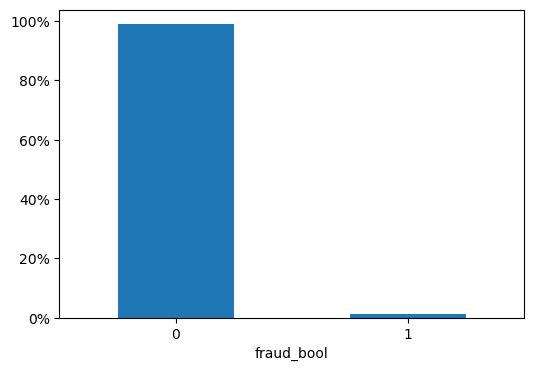

In [21]:
# visualization

ax = fraud_distr.toPandas().plot(
    kind="bar", x="fraud_bool", y="Count(%)", legend=False, figsize=(6,4), rot=0
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [22]:
# Split data (80/20) in a stratified fashion using the target variable

train = df.sampleBy(col="fraud_bool", fractions={0: 0.8, 1: 0.8}, seed=42)
test = df.exceptAll(train)

print("Train set:")
var_distribution(train, "fraud_bool").show()

print("Test set:")
var_distribution(test, "fraud_bool").show()

Train set:
+----------+------+--------+
|fraud_bool| Count|Count(%)|
+----------+------+--------+
|         0|791447|    98.9|
|         1|  8828|     1.1|
+----------+------+--------+

Test set:
+----------+------+--------+
|fraud_bool| Count|Count(%)|
+----------+------+--------+
|         0|197524|    98.9|
|         1|  2201|     1.1|
+----------+------+--------+



## Missing values and distribution of variables

### Numerical variables

In [23]:
# Computes basic statistics

train.describe(numerical_vars + binary_vars).toPandas().set_index("summary").T

summary                            count                 mean  \
days_since_request                800275   1.0282964111059836   
intended_balcon_amount            800275    8.651628997096058   
proposed_credit_limit             800275    515.1914779294617   
income                            800275    0.562797163475085   
name_email_similarity             800275  0.49345814826030554   
velocity_4w                       800275    4856.134450886768   
velocity_6h                       800275    5664.925838884416   
credit_risk_score                 800275    130.9560113710912   
device_distinct_emails_8w         800275   1.0183349473618444   
zip_count_4w                      800275    1573.052217050389   
velocity_24h                      800275    4770.308025456334   
bank_branch_count_8w              800275    184.3977445253194   
date_of_birth_distinct_emails_4w  800275    9.504467839180283   
current_address_months_count      800275    86.54822029927213   
bank_months_count                 800275   10.835561525725533   
session_length_in_minutes         800275    7.544601343584142   
month                             800275   3.2895642123020212   
prev_address_months_count         800275   16.719930024054232   
customer_age                      800275    33.68919433944581   
keep_alive_session                800275   0.5767804817094124   
email_is_free                     800275   0.5298178751054325   
has_other_cards                   800275  0.22294711193027397   
foreign_request                   800275  0.02531504795226641   
phone_mobile_valid                800275   0.8896866702071163   
phone_home_valid                  800275  0.41724907063197025   

summary                                        stddev                    min  \
days_since_request                  5.399944304436769   4.036859788721786E-9   
intended_balcon_amount              20.23278383843544    -15.530554840076814   
proposed_credit_limit               487.0846641384438                  190.0   
income                             0.2903019487079168                    0.1   
name_email_similarity             0.28909587486469557  1.4345504845275636E-6   
velocity_4w                         920.0587642502196      2825.748405284728   
velocity_6h                        3009.3130528267234    -155.43073035695943   
credit_risk_score                    69.6538839248819                   -170   
device_distinct_emails_8w         0.18054445412135797                     -1   
zip_count_4w                         1005.04875004319                      1   
velocity_24h                       1479.4591357248546     1300.3073144849477   
bank_branch_count_8w               459.81703243820147                      0   
date_of_birth_distinct_emails_4w    5.034570702161515                      0   
current_address_months_count        88.38141158425513                     -1   
bank_months_count                  12.119122251555748                     -1   
session_length_in_minutes           8.043996893344081                   -1.0   
month                              2.2102164741091457                      0   
prev_address_months_count          44.058832975735015                     -1   
customer_age                       12.034344141756634                     10   
keep_alive_session                0.49406989652775457                      0   
email_is_free                     0.49911041424338154                      0   
has_other_cards                   0.41622339397275815                      0   
foreign_request                   0.15708032063764754                      0   
phone_mobile_valid                 0.3132801010298297                      0   
phone_home_valid                   0.4931050471502172                      0   

summary                                          max  
days_since_request                 78.45690383509861  
intended_balcon_amount             112.9569276953714  
proposed_credit_limit                         2100.0  
income  

In [24]:
# prev_address_months_count variable: missing values 

train.where("prev_address_months_count = -1").count()

570489

In [25]:
# Remove the prev_address_months_count field 
# since it contains too many missing values.

train = train.drop("prev_address_months_count")
test = test.drop("prev_address_months_count")
numerical_vars.remove("prev_address_months_count")

In [26]:
# current_address_months_count variable: missing values

train.where("current_address_months_count = -1").count()

3404

For the `current_address_months_count` attribute, the number of missing values is negligible, so we can fill them.

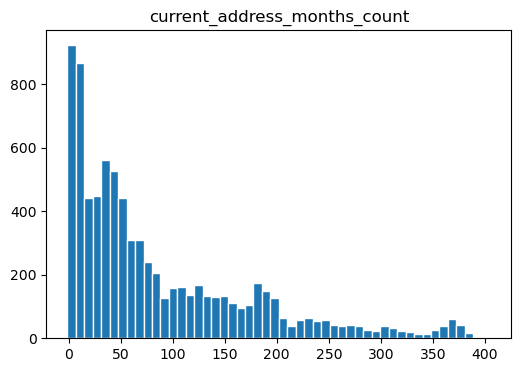

In [27]:
# current_address_months_count distribution using a random sample of 1%

plot_distribution(train, "current_address_months_count")
plt.show()

In [28]:
# Fill missing values with the median

train, test = fill_missing_values(
    train, test, "current_address_months_count", "median"
)

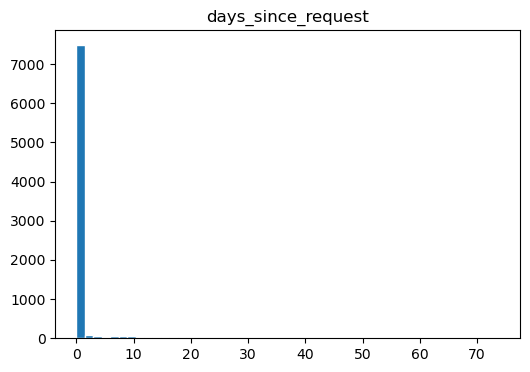

In [29]:
# The days_since_request attribute seems very unbalanced.
# Let's take a random sample of 1% and plot the distribution

plot_distribution(train, "days_since_request")
plt.show()

In [30]:
# Let's check its distribution in detail using hande-made buckets

Bucketizer(splits=[0, 1, 5, 12, 25, 50, float("inf")], 
           inputCol="days_since_request",
           outputCol="days_since_request_CAT"
).transform(train).groupby("days_since_request_CAT").count().show()

+----------------------+------+
|days_since_request_CAT| count|
+----------------------+------+
|                   0.0|734911|
|                   1.0| 21857|
|                   4.0|  2824|
|                   3.0| 15558|
|                   2.0| 22118|
|                   5.0|  3007|
+----------------------+------+



Let's keep the `days_since_request` attribute for now.

In [31]:
# bank_months_count: missing values

train.where("bank_months_count = -1").count()

203017

In [32]:
var_distribution(train, "bank_months_count").show(10)

+-----------------+------+--------+
|bank_months_count| Count|Count(%)|
+-----------------+------+--------+
|               -1|203017|   25.37|
|                1|155956|   19.49|
|               28| 64331|    8.04|
|               15| 47023|    5.88|
|               30| 40746|    5.09|
|               31| 36779|     4.6|
|               25| 32276|    4.03|
|               10| 29628|     3.7|
|               20| 24596|    3.07|
|               21| 23288|    2.91|
+-----------------+------+--------+
only showing top 10 rows



In [33]:
# Remove the bank_months_count attribute

train = train.drop("bank_months_count")
test = test.drop("bank_months_count")
numerical_vars.remove("bank_months_count")

In [34]:
# session_length_in_minutes: missing values

train.where("session_length_in_minutes = -1").count()

1606

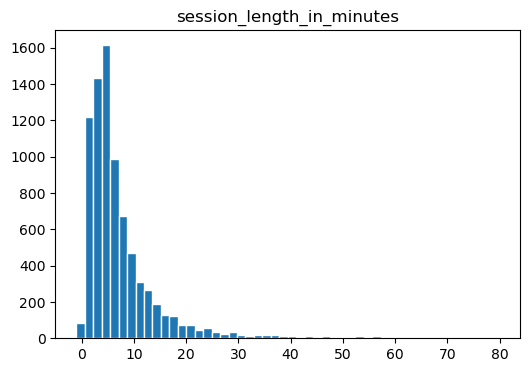

In [35]:
plot_distribution(train, "session_length_in_minutes")
plt.show()

In [36]:
# Fill missing values with the median

train, test = fill_missing_values(
    train, test, "session_length_in_minutes", "median"
)

In [37]:
# device_distinct_emails_8w: missing values

train.where("device_distinct_emails_8w = -1").count()

285

In [38]:
var_distribution(train, "device_distinct_emails_8w").show()

+-------------------------+------+--------+
|device_distinct_emails_8w| Count|Count(%)|
+-------------------------+------+--------+
|                        1|774775|   96.81|
|                        2| 20229|    2.53|
|                        0|  4986|    0.62|
|                       -1|   285|    0.04|
+-------------------------+------+--------+



In [39]:
# The variable device_distinct_emails_8w has a very low 
# discriminating capability. Let's keep it for now.
# Replace missing values with the mode.

train, test = fill_missing_values(
    train, test, "device_distinct_emails_8w", "mode"
)

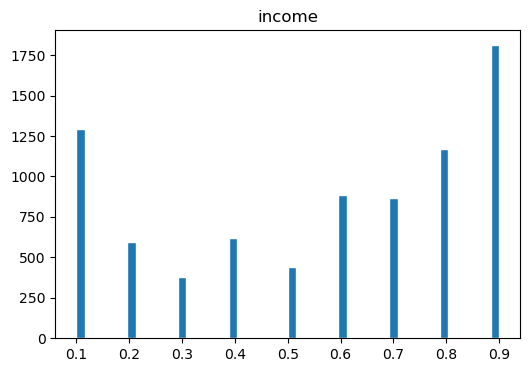

In [40]:
plot_distribution(train, "income")
plt.show()

### Nominal variables

In [41]:
# Check the distribution of the categoriacl variables

for var in nominal_vars:
    var_distribution(train, var).show()

+------------+------+--------+
|payment_type| Count|Count(%)|
+------------+------+--------+
|          AB|296593|   37.06|
|          AA|206491|    25.8|
|          AC|201793|   25.22|
|          AD| 95166|   11.89|
|          AE|   232|    0.03|
+------------+------+--------+

+-----------------+------+--------+
|employment_status| Count|Count(%)|
+-----------------+------+--------+
|               CA|584538|   73.04|
|               CB|110510|   13.81|
|               CF| 35318|    4.41|
|               CC| 30222|    3.78|
|               CD| 21262|    2.66|
|               CE| 18070|    2.26|
|               CG|   355|    0.04|
+-----------------+------+--------+

+--------------+------+--------+
|housing_status| Count|Count(%)|
+--------------+------+--------+
|            BC|298052|   37.24|
|            BB|208600|   26.07|
|            BA|135741|   16.96|
|            BE|135426|   16.92|
|            BD| 20919|    2.61|
|            BF|  1338|    0.17|
|            BG|   199|   

In [42]:
# Check the joint distribution between the `source` and target variable

n_internet = train.where(train.source == "INTERNET").count()
n_teleapp = train.count() - n_internet

temp = train.groupby(["source", "fraud_bool"]).count()\
    .withColumnRenamed("count", "Count")

temp = temp.withColumn(
    "Count(%)", 
    F.when(
        temp.source == "INTERNET", 
        F.round(temp.Count / n_internet * 100, 2)
    ).otherwise(F.round(temp.Count / n_teleapp * 100, 2))
).show()

del temp

+--------+----------+------+--------+
|  source|fraud_bool| Count|Count(%)|
+--------+----------+------+--------+
| TELEAPP|         0|  5540|   98.38|
|INTERNET|         1|  8737|     1.1|
| TELEAPP|         1|    91|    1.62|
|INTERNET|         0|785907|    98.9|
+--------+----------+------+--------+



The `source` variable does not seem to make any difference in the prediction of the target variable. However, people using the bank's app may share common characteristics that could arise from clustering analysis. For the time being, let us keep it in the dataset.

In [43]:
# Check for duplicates records

train.count() - train.dropDuplicates().count()

0

In [51]:
# Save train and test sets

# train.write.option("header", True) \
#            .parquet(path="train_post_exploration", mode="overwrite")

# test.write.option("header", True) \
#           .parquet(path="test_post_exploration", mode="overwrite")

In [52]:
# Save variables names by types

vars_by_types = dict(zip(
    ["nominal_vars", "numerical_vars", "binary_vars"], 
    [nominal_vars, numerical_vars, binary_vars]
))

with open("vars_by_types", "wb") as f:
        pickle.dump(vars_by_types, f)

# Cluster analysis

## Preprocessing

In [53]:
# Custom functions

def clustering_evaluation(models: "iterable", featuresCol: str) -> pysparkDF:
    """
    For each model in the input iterator show the number of clusters, the 
    distance measure, the SSE and the silhouette score. Return a list of tuples.
    For the sake of comparison, no matter which distance measure is used in the
    model, the silhouette score is always calculated with the Euclidean distance.
    """
    results = []
    for _, model in models:
        k = model.getK()
        dist = model.getDistanceMeasure()
        sse = model.summary.trainingCost
        evaluator = ClusteringEvaluator(featuresCol=featuresCol)
        silh = evaluator.evaluate(model.summary.predictions)
        results.append((k, dist, round(sse, 3), round(silh, 3)))
    
    schema = ["k", "distance", "SSE", "silhouette"]
    return spark.createDataFrame(results, schema=schema)


def kmeans_model_selection(train: pysparkDF, featureCol: str, 
                           k_range=range(2, 11)) -> None:
    """
    Run kmeans with a number of clusters ranging from 2 to 10 and
    evaluate the clusterings with statistics and the plots of centroids.
    """
    # Instantiate and fit kmeans
    kmeans = KMeans(featuresCol=featureCol, initSteps=5, maxIter=10, seed=42)
    params = [{kmeans.k: n, kmeans.distanceMeasure: "euclidean"} for n in k_range]
    kmeans_models = kmeans.fitMultiple(train, params)

    # Parallel plot
    fig, axes = plt.subplots(ncols=2, nrows=5, figsize = (16,20), tight_layout=True)
    axes = axes.flatten()    
    for i, model in kmeans_models:
        plot_centroids(model.clusterCenters(), ax=axes[i])
        axes[i].legend(ncols=4)

        # Clustering evaluation
        k = model.getK()
        sse = model.summary.trainingCost
        evaluator = ClusteringEvaluator(featuresCol=featureCol)
        silh = evaluator.evaluate(model.summary.predictions)
        print(f"k = {k}, SSE = {sse}, Silhouette = {silh}")    

    fig.suptitle(featureCol, fontsize=18)
    plt.show()

def plot_clustering_score(model_name: str, features: list[str], 
                          score: str) -> plt.Axes:
    """
    This function is not well generalized. It compares grapichally the same
    clustering algorithm trained with different vector features. It assumes 
    that for each vector of features in the input list (say feature_name) 
    you have a summary dataframe named as `model_name` + `_` + `feature_name`
    saved locally. Moreover, it assumes that the loaded dataframe has a 
    column named `distance` and that the clustering algorithm was runned 
    using both the euclidean and the cosine distance.
    """
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, 
                             figsize=(10,3), tight_layout=True)

    for i, feature in enumerate(features):
        model_res = spark.read.option("header", True)\
            .parquet(model_name + "_" + feature)
        pandas_df = model_res.toPandas().sort_values("k")

        pandas_df.loc[pandas_df.distance == "euclidean"].plot(
            x="k", y=score, xlabel="", legend=False, title=feature, ax=axes[i]
        )

        pandas_df.loc[pandas_df.distance == "cosine"].plot(
            x="k", y=score, xlabel="", legend=False, title=feature, ax=axes[i]
        )
    
    labels=["euclidean", "cosine"]
    fig.legend(labels, loc='lower left', bbox_to_anchor=(0.11,-0.01), 
               ncol=2, bbox_transform=fig.transFigure)
    fig.supylabel(score)
    fig.supxlabel("Number of clusters")
    
    return axes

def plot_centroids(centroids: "list[arrays-like]", title: bool = True, ax=None):
    """
    Plot centroids to study how clusters distribute in the feature space.  
    """
    if ax is None:
        fig, ax = plt.subplots()
    k = len(centroids)
    clusters = ['C'+str(i) for i in range(1,k+1)]
    for i, C in enumerate(centroids):
        ax.plot(C, marker='o', label = clusters[i]) 
        
    if title:
        plt.title(f'{k} clusters')
    attr = range(len(centroids[0]))
    ax.set_xticks(attr, attr)
    ax.set_xlim([0,len(attr)-1])
    ax.set_xlabel("Attribute Indexes")
    ax.grid(visible=True, axis='x')
    
    return ax

def feature_mapper(df: pysparkDF, var: str) -> dict:
    metadata = df.schema[var].metadata["ml_attr"]["attrs"]
    tmp = []
    dct = {}
    for _, lst in metadata.items():
        tmp += lst
    for d in tmp:
        dct[d["idx"]] = d["name"]
    return dct

In [55]:
# load train and test sets

# train = spark.read.option("header", True).parquet("train_post_exploration")
# test = spark.read.option("header", True).parquet("test_post_exploration")

In [56]:
with open("vars_by_types", "rb") as f:
    vars_by_types = pickle.load(f)

In [57]:
vars_by_types.keys()

dict_keys(['nominal_vars', 'numerical_vars', 'binary_vars'])

In [58]:
# Prepare the dataset for the clustering analysis

# Encodes nominal features with label indices
nominal_outputs_indexer = [name + "_indexed" for name in vars_by_types["nominal_vars"]]
indexer = StringIndexer(inputCols=vars_by_types["nominal_vars"], 
                        outputCols=nominal_outputs_indexer)

# Apply one hot encoding to the nominal variables
nominal_outputs_ohe = [name + "_ohe" for name in nominal_outputs_indexer]
ohe = OneHotEncoder(inputCols=nominal_outputs_indexer, outputCols=nominal_outputs_ohe)

# Put together all ohe variables
assembler1 = VectorAssembler(inputCols=nominal_outputs_ohe, 
                             outputCol="ohe_vars")

# Put together all binary variables
assembler2 = VectorAssembler(inputCols=vars_by_types["binary_vars"], 
                             outputCol="binary_vars")

# Put together all numerical vars
assembler3 = VectorAssembler(inputCols=vars_by_types["numerical_vars"],
                             outputCol="numerical_vars")

# Scale numerical vars
scaler1 = StandardScaler(withMean=True, inputCol="numerical_vars",
                        outputCol="numerical_vars_scaled")

# Put together binary and ohe variables
assembler4 = VectorAssembler(inputCols=["binary_vars", "ohe_vars"],
                             outputCol="binary_ohe_vars")

# Put together numerical, binary and ohe variables
assembler5 = VectorAssembler(inputCols=["numerical_vars", "binary_ohe_vars"], 
                            outputCol="numerical_binary_ohe_vars")

# Standardize the last vector
scaler2 = StandardScaler(withMean=True, 
                         inputCol="numerical_binary_ohe_vars", 
                         outputCol="numerical_binary_ohe_vars_scaled")

# Set pipeline
pipeline_stages = [indexer, ohe, assembler1, assembler2, assembler3,
                   scaler1, assembler4, assembler5, scaler2]
pipeline_model = Pipeline(stages=pipeline_stages).fit(train)
train = pipeline_model.transform(train)
test = pipeline_model.transform(test)

In [59]:
train.schema["numerical_binary_ohe_vars"].metadata["ml_attr"]["num_attrs"]

44

In the vector where we put together the numerical, binary and ohe variables we have 44 features because for each nominal variable with $n$ distinct values the ohe produces $n-1$ binary variables (to avoid the vector entries be linearly dependent).

In [60]:
# Correlation (Pearson) 

corr_df = Correlation.corr(train, column="numerical_binary_ohe_vars")

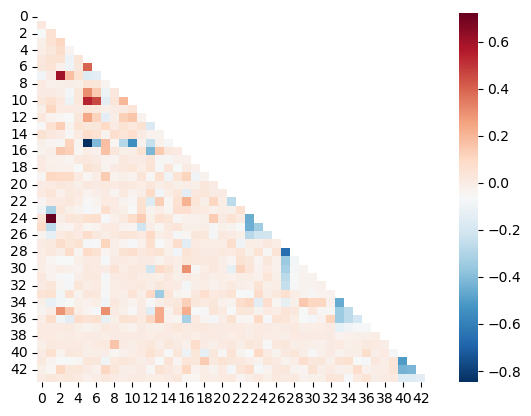

In [61]:
corr_mtx = corr_df.collect()[0][0].toArray()
mask = np.zeros_like(corr_mtx, dtype=int)
mask[np.triu_indices_from(mask)] = 1
np.fill_diagonal(mask, 1)
my_color = sns.color_palette('RdBu_r', n_colors = 9, as_cmap = True)
sns.heatmap(corr_mtx, mask=mask, annot=False, cbar=True, cmap=my_color)

plt.show()

In [62]:
mtx = corr_mtx.copy() 
np.fill_diagonal(mtx, 0)
bool_mtx = (mtx > 0.5) | (mtx < -0.5 )

In [63]:
corr_pairs = {frozenset(p) for p in np.stack(np.where(bool_mtx), axis=1)}
corr_pairs = [tuple(p) for p in corr_pairs]
corr_pairs

[(10, 15), (40, 41), (5, 15), (27, 28), (10, 5), (24, 1), (2, 7)]

In [64]:
mapper = feature_mapper(train, "numerical_binary_ohe_vars")
for idx1, idx2 in corr_pairs:
    attr1 = mapper[idx1]
    attr2 = mapper[idx2]
    corr = corr_mtx[idx1, idx2]
    print((attr1, attr2, round(corr, 3)))

('numerical_vars_velocity_24h', 'numerical_vars_month', -0.55)
('binary_ohe_vars_ohe_vars_device_os_indexed_ohe_other', 'binary_ohe_vars_ohe_vars_device_os_indexed_ohe_linux', -0.51)
('numerical_vars_velocity_4w', 'numerical_vars_month', -0.848)
('binary_ohe_vars_ohe_vars_employment_status_indexed_ohe_CA', 'binary_ohe_vars_ohe_vars_employment_status_indexed_ohe_CB', -0.659)
('numerical_vars_velocity_24h', 'numerical_vars_velocity_4w', 0.539)
('binary_ohe_vars_ohe_vars_payment_type_indexed_ohe_AA', 'numerical_vars_intended_balcon_amount', 0.723)
('numerical_vars_proposed_credit_limit', 'numerical_vars_credit_risk_score', 0.606)


In [65]:
# Correlation (Spearman) 

corr_df = Correlation.corr(train,  method="spearman",
                           column="numerical_binary_ohe_vars")

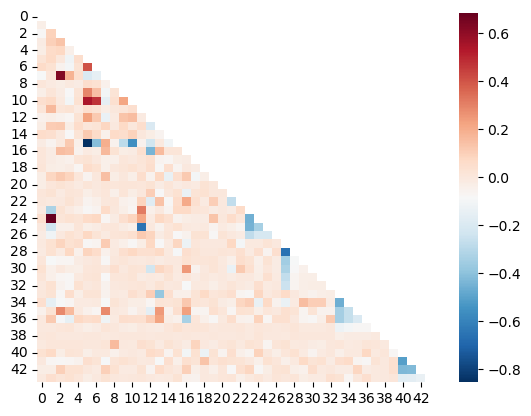

In [66]:
corr_mtx = corr_df.collect()[0][0].toArray()
mask = np.zeros_like(corr_mtx, dtype=int)
mask[np.triu_indices_from(mask)] = 1
np.fill_diagonal(mask, 1)
my_color = sns.color_palette('RdBu_r', n_colors = 9, as_cmap = True)
sns.heatmap(corr_mtx, mask=mask, annot=False, cbar=True, cmap=my_color)

plt.show()

In [67]:
mtx = corr_mtx.copy() 
np.fill_diagonal(mtx, 0)
bool_mtx = (mtx > 0.5) | (mtx < -0.5 )

In [68]:
corr_pairs = {frozenset(p) for p in np.stack(np.where(bool_mtx), axis=1)}
corr_pairs = [tuple(p) for p in corr_pairs]
corr_pairs

[(10, 15), (40, 41), (5, 15), (27, 28), (10, 5), (24, 1), (25, 11), (2, 7)]

In [69]:
for idx1, idx2 in corr_pairs:
    attr1 = mapper[idx1]
    attr2 = mapper[idx2]
    corr = corr_mtx[idx1, idx2]
    print((attr1, attr2, round(corr, 3)))

('numerical_vars_velocity_24h', 'numerical_vars_month', -0.555)
('binary_ohe_vars_ohe_vars_device_os_indexed_ohe_other', 'binary_ohe_vars_ohe_vars_device_os_indexed_ohe_linux', -0.51)
('numerical_vars_velocity_4w', 'numerical_vars_month', -0.854)
('binary_ohe_vars_ohe_vars_employment_status_indexed_ohe_CA', 'binary_ohe_vars_ohe_vars_employment_status_indexed_ohe_CB', -0.659)
('numerical_vars_velocity_24h', 'numerical_vars_velocity_4w', 0.546)
('binary_ohe_vars_ohe_vars_payment_type_indexed_ohe_AA', 'numerical_vars_intended_balcon_amount', 0.685)
('binary_ohe_vars_ohe_vars_payment_type_indexed_ohe_AC', 'numerical_vars_bank_branch_count_8w', -0.655)
('numerical_vars_proposed_credit_limit', 'numerical_vars_credit_risk_score', 0.631)


In [70]:
# Let's see if there exists a correlation between the 
# target variable and the month of applications

train.groupby("fraud_bool", "month").count()\
    .sort("count", ascending=False)\
    .where("fraud_bool = 1").show()

+----------+-----+-----+
|fraud_bool|month|count|
+----------+-----+-----+
|         1|    0| 1201|
|         1|    4| 1160|
|         1|    6| 1156|
|         1|    7| 1154|
|         1|    5| 1132|
|         1|    3| 1110|
|         1|    1|  969|
|         1|    2|  946|
+----------+-----+-----+



In [71]:
# correlation between age and fraud

train.groupby("fraud_bool", "customer_age").count()\
    .sort("count", ascending=False)\
    .where("fraud_bool = 1").show()

+----------+------------+-----+
|fraud_bool|customer_age|count|
+----------+------------+-----+
|         1|          40| 2314|
|         1|          50| 2231|
|         1|          30| 2063|
|         1|          20|  969|
|         1|          60|  932|
|         1|          70|  208|
|         1|          10|   55|
|         1|          80|   53|
|         1|          90|    3|
+----------+------------+-----+



In [72]:
ChiSquareTest.test(train, "binary_ohe_vars", "fraud_bool", True)\
    .show(30, truncate=False)

+------------+---------------------+----------------+-------------------+
|featureIndex|pValue               |degreesOfFreedom|statistic          |
+------------+---------------------+----------------+-------------------+
|0           |0.0                  |1               |2068.912822158405  |
|24          |0.0                  |1               |1222.5178595651116 |
|12          |0.0                  |1               |289.6232141683418  |
|13          |0.0                  |1               |614.7196142374967  |
|25          |0.0                  |1               |4897.685521428663  |
|1           |0.0                  |1               |629.1608511493807  |
|14          |0.0                  |1               |107.15191158154313 |
|26          |6.673454011618674E-10|1               |38.11385614476452  |
|2           |0.0                  |1               |969.8799097807643  |
|15          |0.0                  |1               |128.4693788494221  |
|3           |0.0                  |1 

In [73]:
train.schema["binary_ohe_vars"].metadata

{'ml_attr': {'attrs': {'numeric': [{'idx': 0,
     'name': 'binary_vars_keep_alive_session'},
    {'idx': 1, 'name': 'binary_vars_email_is_free'},
    {'idx': 2, 'name': 'binary_vars_has_other_cards'},
    {'idx': 3, 'name': 'binary_vars_foreign_request'},
    {'idx': 4, 'name': 'binary_vars_phone_mobile_valid'},
    {'idx': 5, 'name': 'binary_vars_phone_home_valid'}],
   'binary': [{'idx': 6, 'name': 'ohe_vars_payment_type_indexed_ohe_AB'},
    {'idx': 7, 'name': 'ohe_vars_payment_type_indexed_ohe_AA'},
    {'idx': 8, 'name': 'ohe_vars_payment_type_indexed_ohe_AC'},
    {'idx': 9, 'name': 'ohe_vars_payment_type_indexed_ohe_AD'},
    {'idx': 10, 'name': 'ohe_vars_employment_status_indexed_ohe_CA'},
    {'idx': 11, 'name': 'ohe_vars_employment_status_indexed_ohe_CB'},
    {'idx': 12, 'name': 'ohe_vars_employment_status_indexed_ohe_CF'},
    {'idx': 13, 'name': 'ohe_vars_employment_status_indexed_ohe_CC'},
    {'idx': 14, 'name': 'ohe_vars_employment_status_indexed_ohe_CD'},
    {'idx': 

## Numerical variables

k = 2, SSE = 12906206.891885905, Silhouette = 0.25025133601810917
k = 3, SSE = 11252367.7148133, Silhouette = 0.1841589799318661
k = 4, SSE = 10924284.33557264, Silhouette = 0.16818484573516038
k = 5, SSE = 10384656.60301099, Silhouette = 0.19131430496058394
k = 6, SSE = 9776526.720527, Silhouette = 0.21065845727773402
k = 7, SSE = 9657774.167557849, Silhouette = 0.13929505685665525
k = 8, SSE = 9336595.983883364, Silhouette = 0.16048763903905924
k = 9, SSE = 8877098.803872595, Silhouette = 0.12863058955406478
k = 10, SSE = 8853447.139573162, Silhouette = 0.12826674010386627


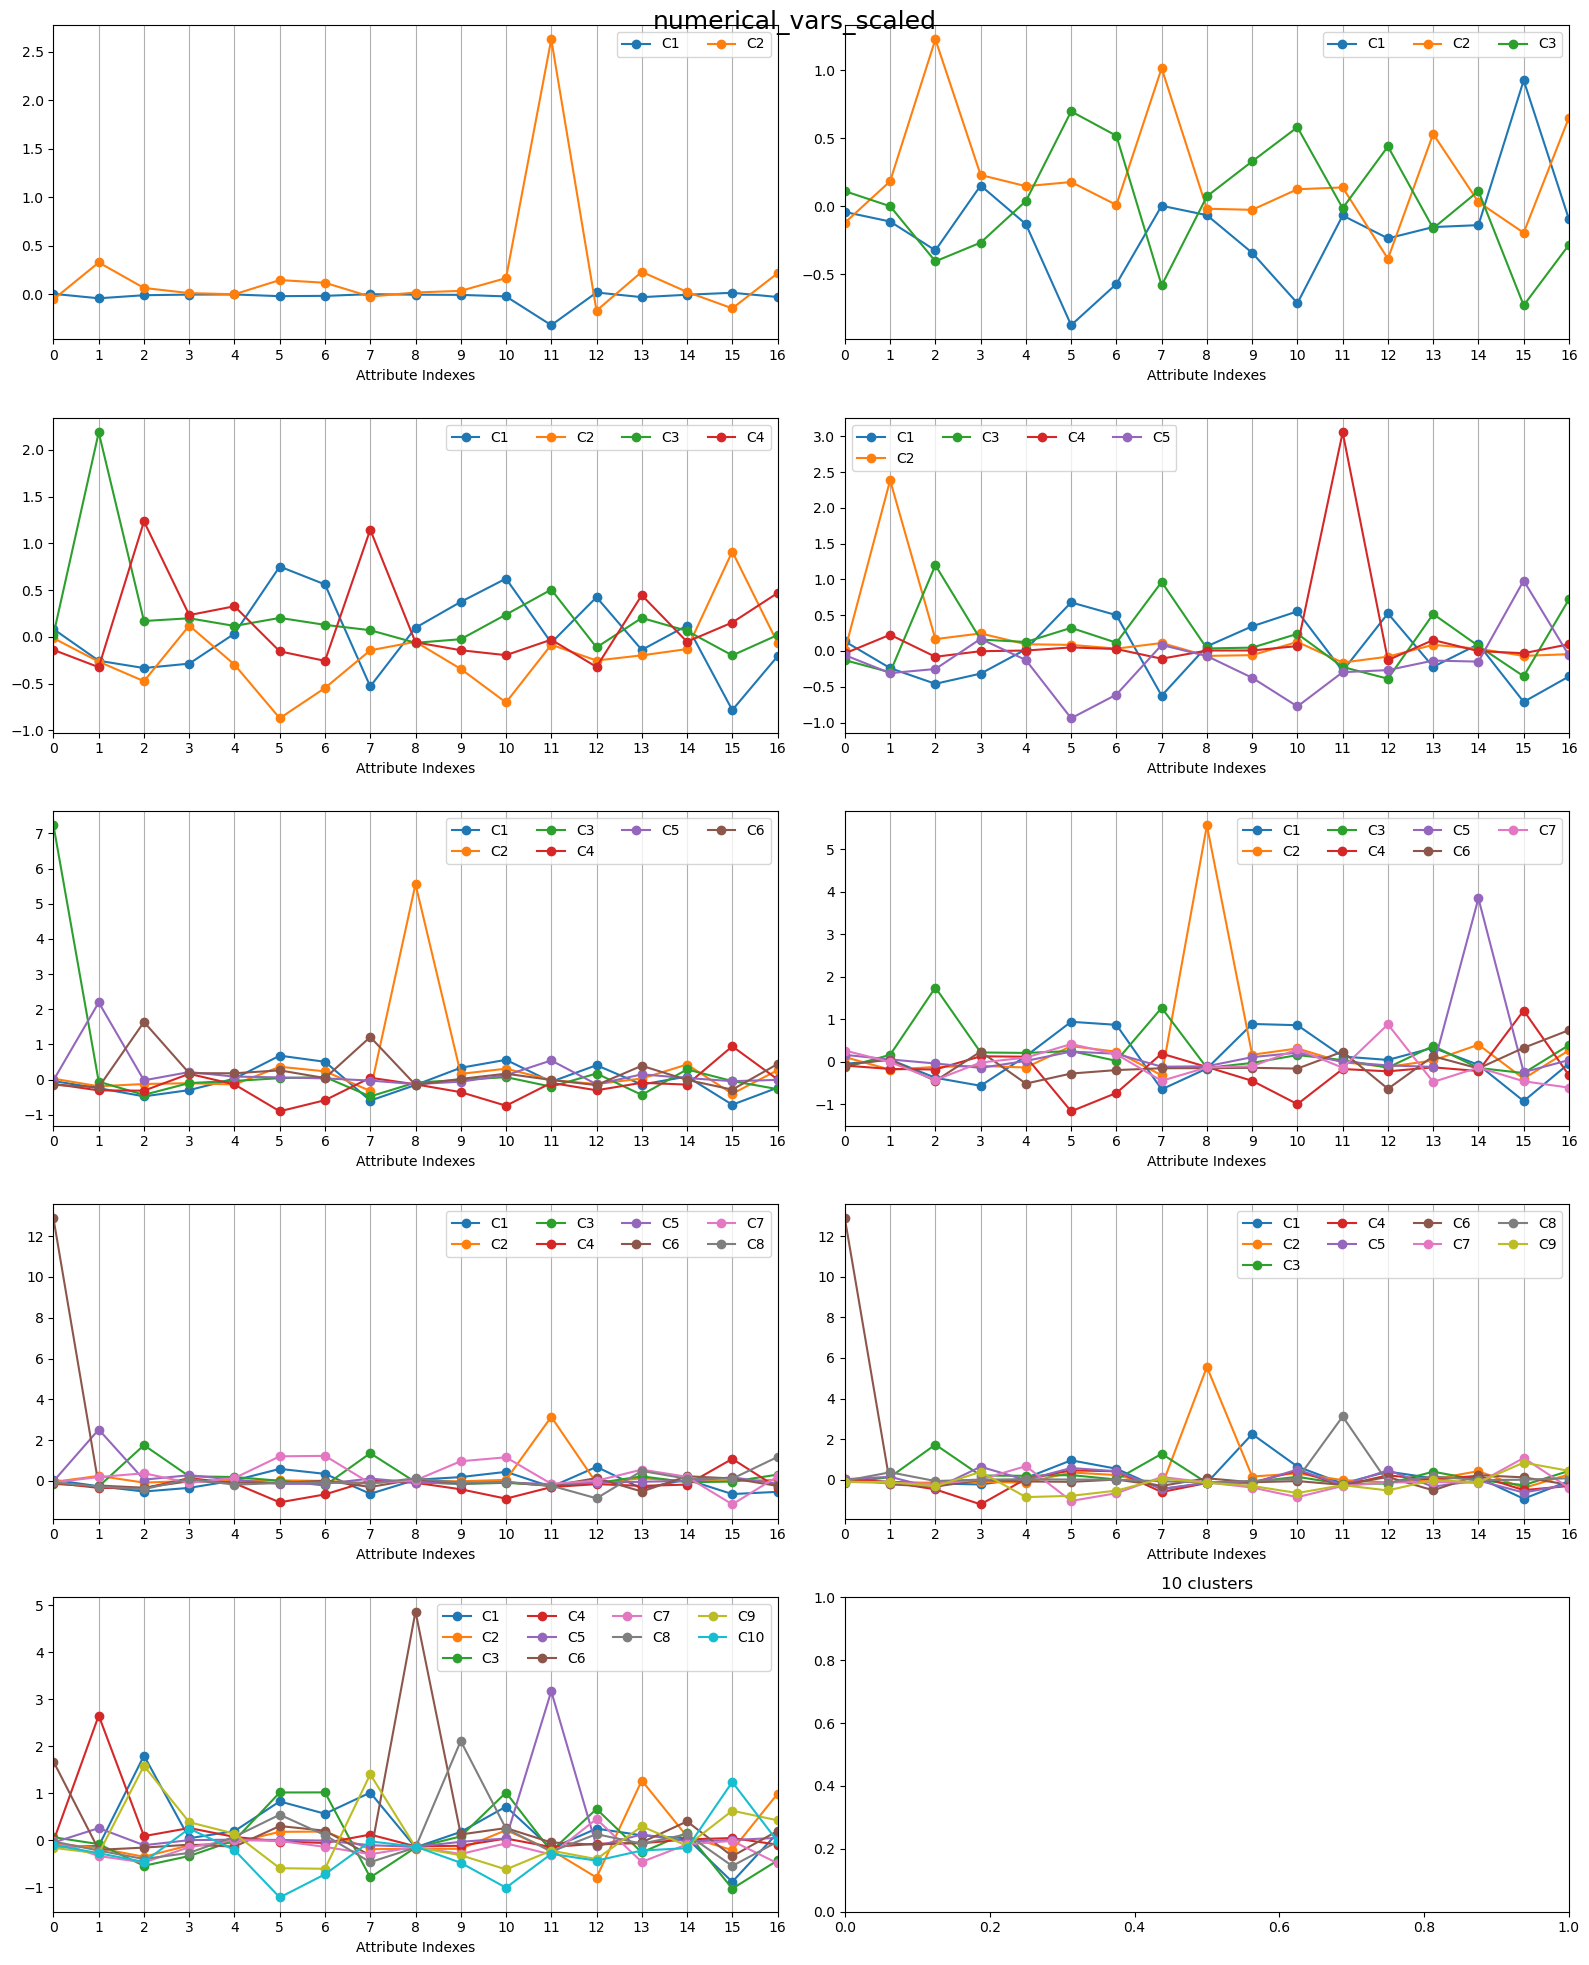

In [74]:
kmeans_model_selection(train, "numerical_vars_scaled")

## Numerical and binary variables

k = 2, SSE = 33473039.934480935, Silhouette = 0.09481911868646135
k = 3, SSE = 32709067.999729298, Silhouette = 0.10187628759196085
k = 4, SSE = 31731097.60427387, Silhouette = 0.08543595250480193
k = 5, SSE = 30960841.518984735, Silhouette = 0.10386340138745988
k = 6, SSE = 29711664.692086756, Silhouette = 0.10899452384962616
k = 7, SSE = 29019922.108280003, Silhouette = 0.08130653799073972
k = 8, SSE = 28192061.696668305, Silhouette = 0.11776751438362408
k = 9, SSE = 27946590.380042, Silhouette = 0.11469738320502472
k = 10, SSE = 27013832.517151758, Silhouette = 0.11732831922569284


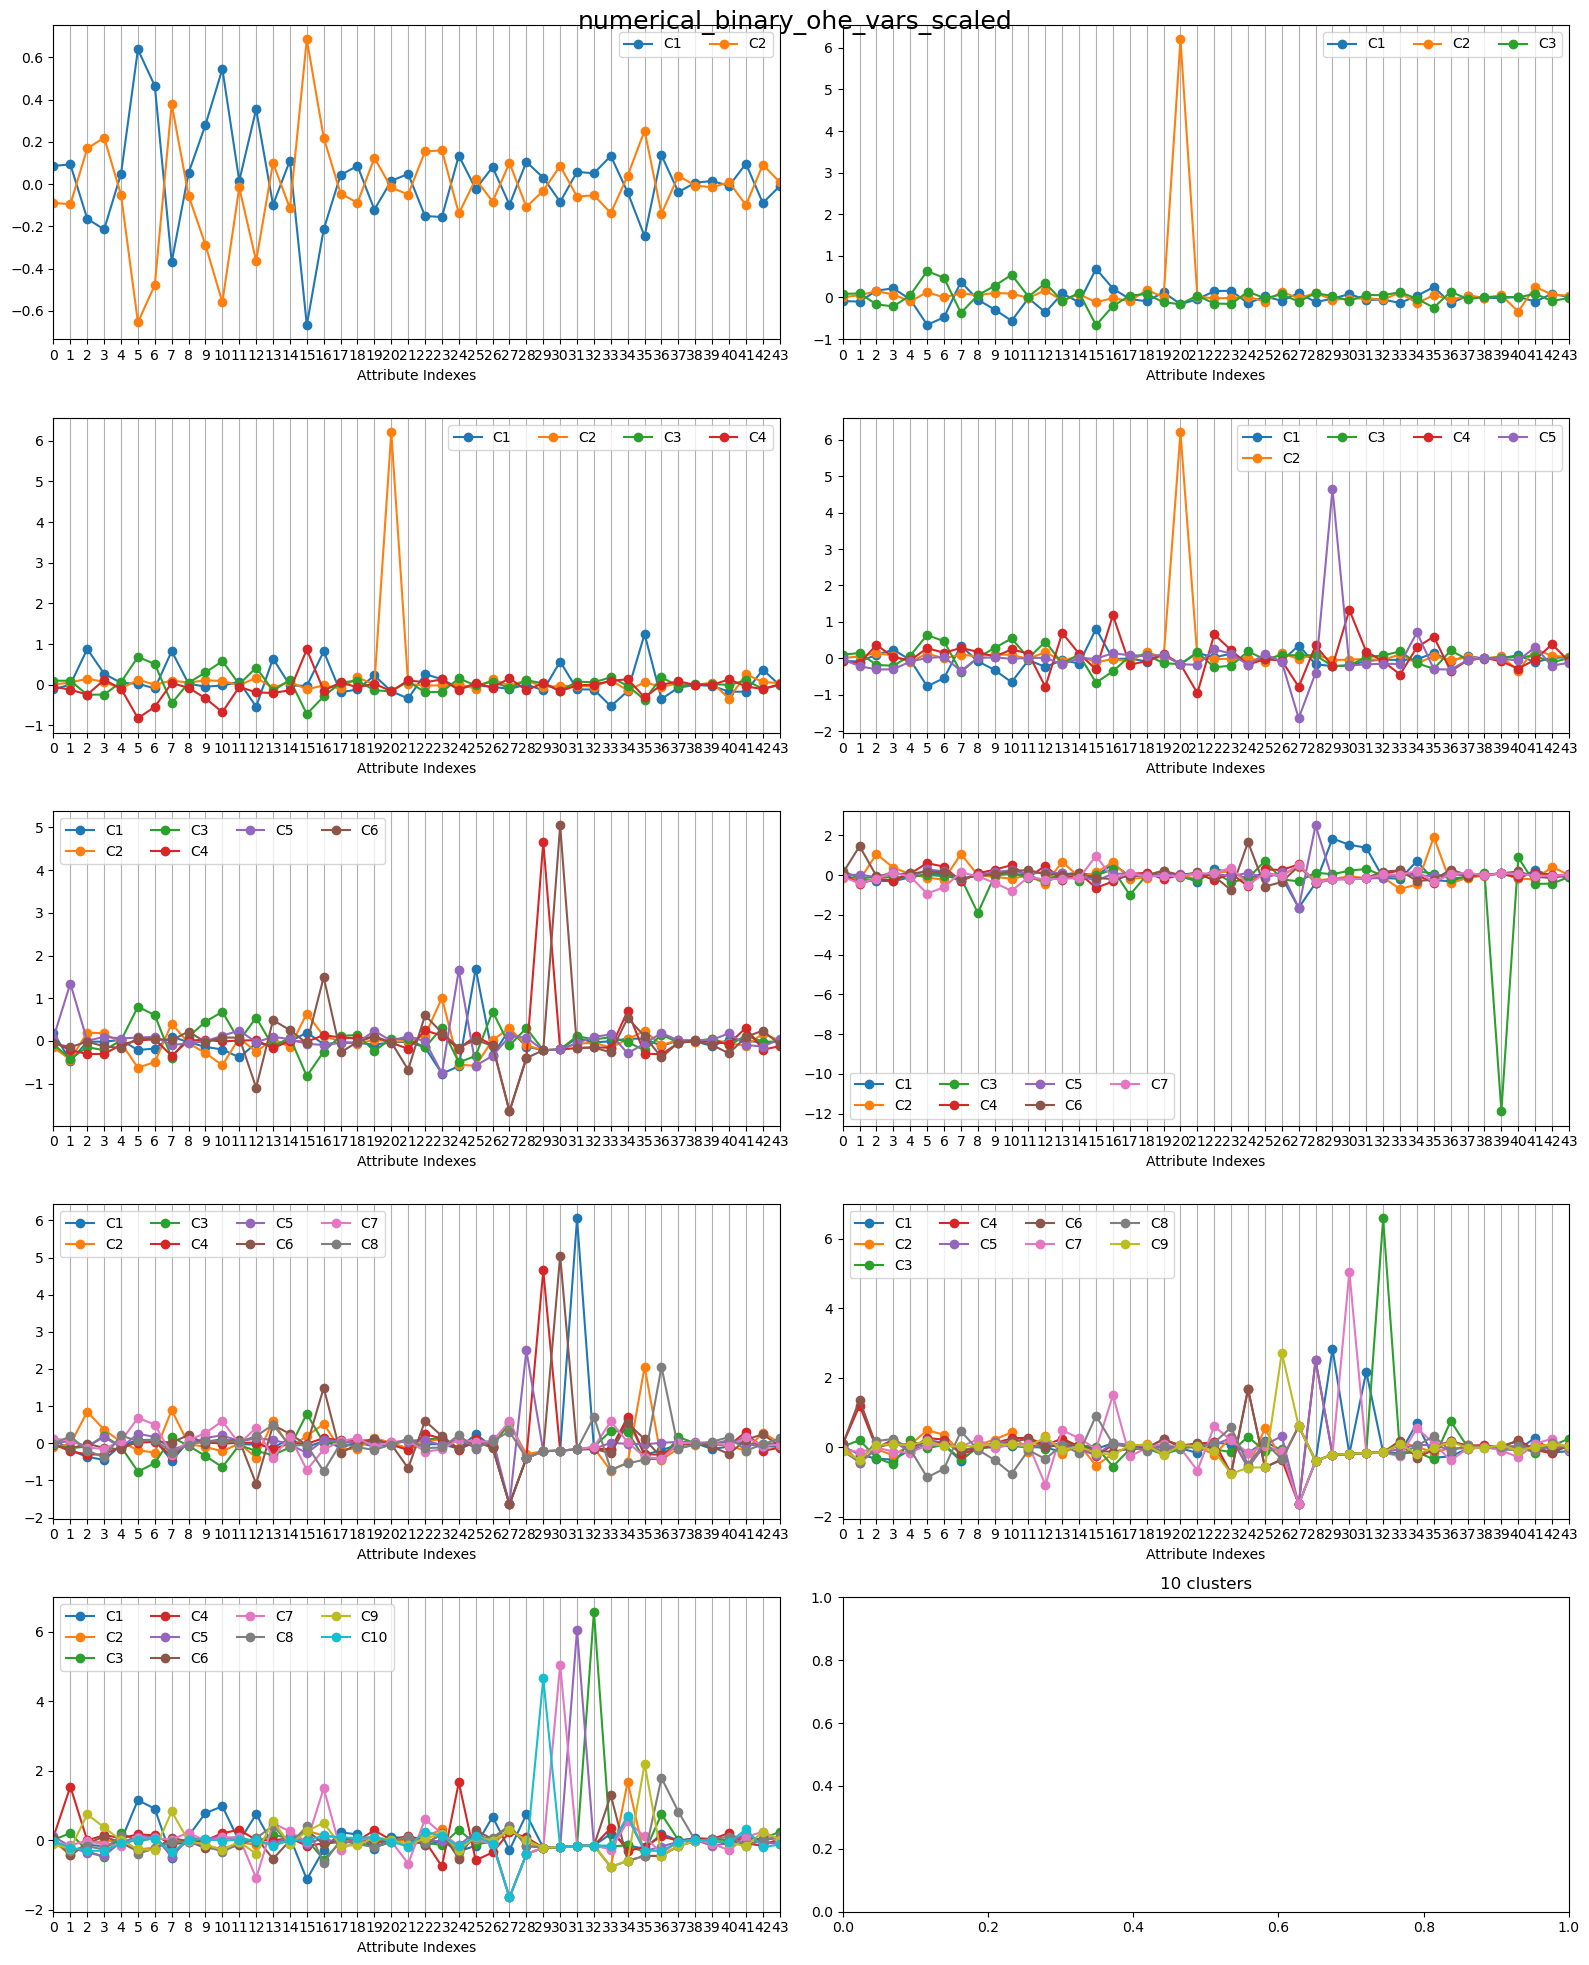

In [75]:
kmeans_model_selection(train, "numerical_binary_ohe_vars_scaled")

Binary variables are problematic because spark does not provide a suitable dissimilarity function. Indeed if we remove them from the dataset we obtain a larger silhouette score.

## Principal components analysis

### PCA on all the attributes

In [76]:
train.schema["numerical_binary_ohe_vars_scaled"].metadata

{'ml_attr': {'num_attrs': 44}}

In [77]:
# PCA all variables

n = train.schema["numerical_binary_ohe_vars_scaled"].metadata["ml_attr"]["num_attrs"]
pca = PCA(k=n, inputCol="numerical_binary_ohe_vars_scaled", outputCol="numerical_binary_ohe_vars_scaled_pca_full")
pca_model = pca.fit(train)
train = pca_model.transform(train)
test = pca_model.transform(test)

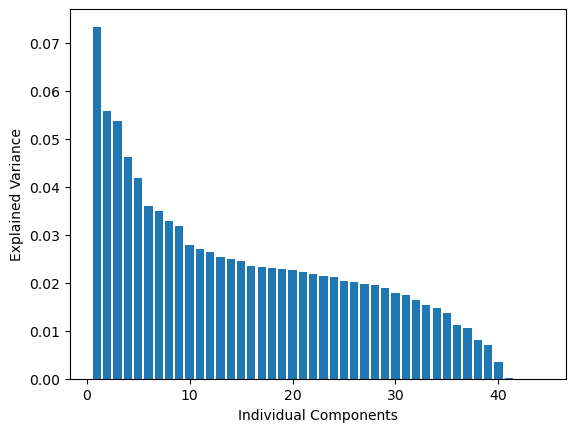

In [78]:
# Explained variance by single components

plt.bar(range(1,n+1), pca_model.explainedVariance)
plt.ylabel("Explained Variance")
plt.xlabel("Individual Components")
plt.show()

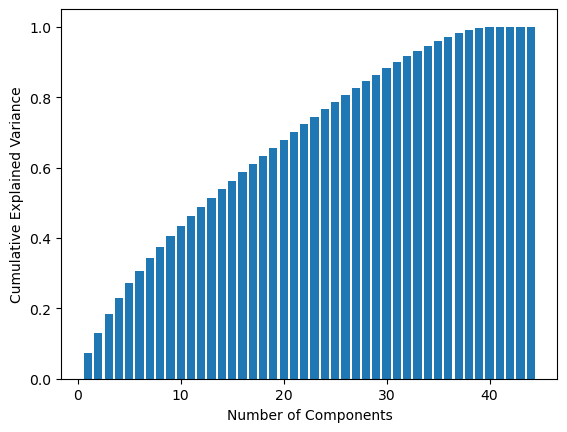

In [79]:
# cumulative explained variance

plt.bar(range(1,n+1), list(accumulate(pca_model.explainedVariance)))
plt.ylabel("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.show()

k = 2, SSE = 33473039.93448094, Silhouette = 0.09481911868646226
k = 3, SSE = 32709067.9997293, Silhouette = 0.10187628759196182
k = 4, SSE = 31731097.604273867, Silhouette = 0.08543595250480222
k = 5, SSE = 30960841.518984728, Silhouette = 0.10386340138746127
k = 6, SSE = 29711664.692086805, Silhouette = 0.10899452384962091
k = 7, SSE = 29019922.108280007, Silhouette = 0.08130653799074168
k = 8, SSE = 28192061.696668316, Silhouette = 0.11776751438362605
k = 9, SSE = 27946590.38004201, Silhouette = 0.11469738320502412
k = 10, SSE = 27013832.517151766, Silhouette = 0.11732831922568956


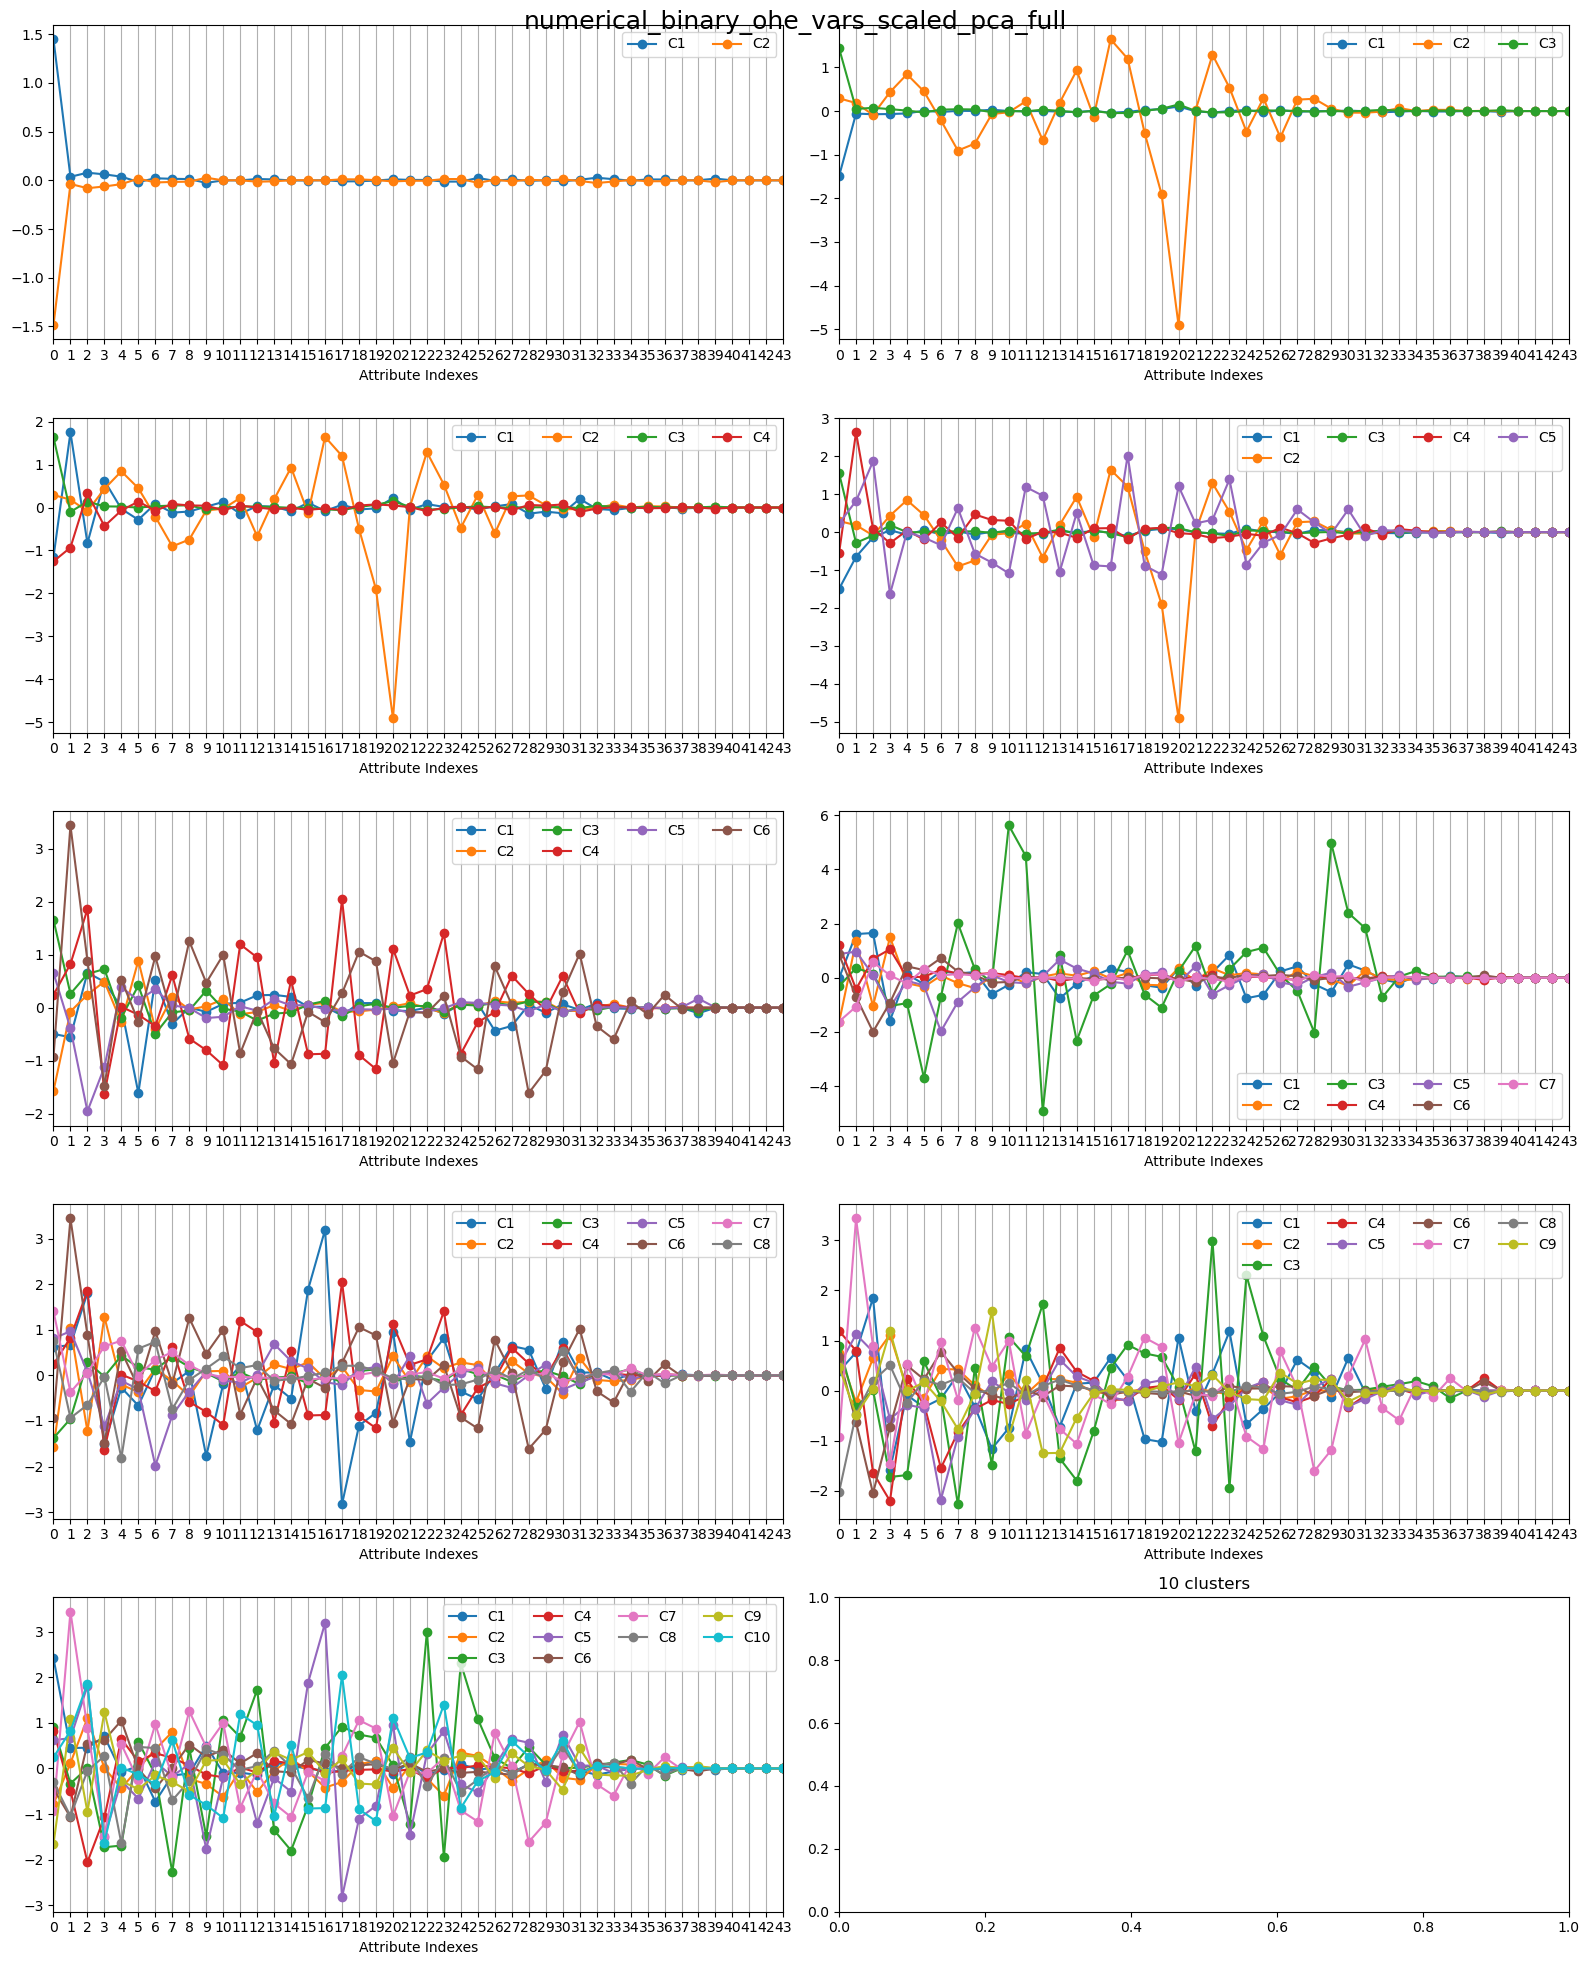

In [80]:
kmeans_model_selection(train, "numerical_binary_ohe_vars_scaled_pca_full")

The last 9 components does not seem to discern among the various clusters, thus we can remove them

In [81]:
train = train.withColumn("numerical_binary_ohe_vars_scaled_pca_35",
                         F.slice(vector_to_array("numerical_binary_ohe_vars_scaled_pca_full"), 1, 35))
test= test.withColumn("numerical_binary_ohe_vars_scaled_pca_35",
                      F.slice(vector_to_array("numerical_binary_ohe_vars_scaled_pca_full"), 1, 35))

k = 2, SSE = 32051572.473010793, Silhouette = 0.09870749522132645
k = 3, SSE = 30827215.773235798, Silhouette = 0.10576581369170068
k = 4, SSE = 30249979.57256861, Silhouette = 0.08561550036621575
k = 5, SSE = 29299912.082792126, Silhouette = 0.10781524527464846
k = 6, SSE = 28522698.38480913, Silhouette = 0.06647371626598579
k = 7, SSE = 27492460.45923204, Silhouette = 0.11424021268187085
k = 8, SSE = 27183142.505695622, Silhouette = 0.10560801299725296
k = 9, SSE = 26887398.148484554, Silhouette = 0.0932652185610748
k = 10, SSE = 25967085.464939065, Silhouette = 0.1184921733326879


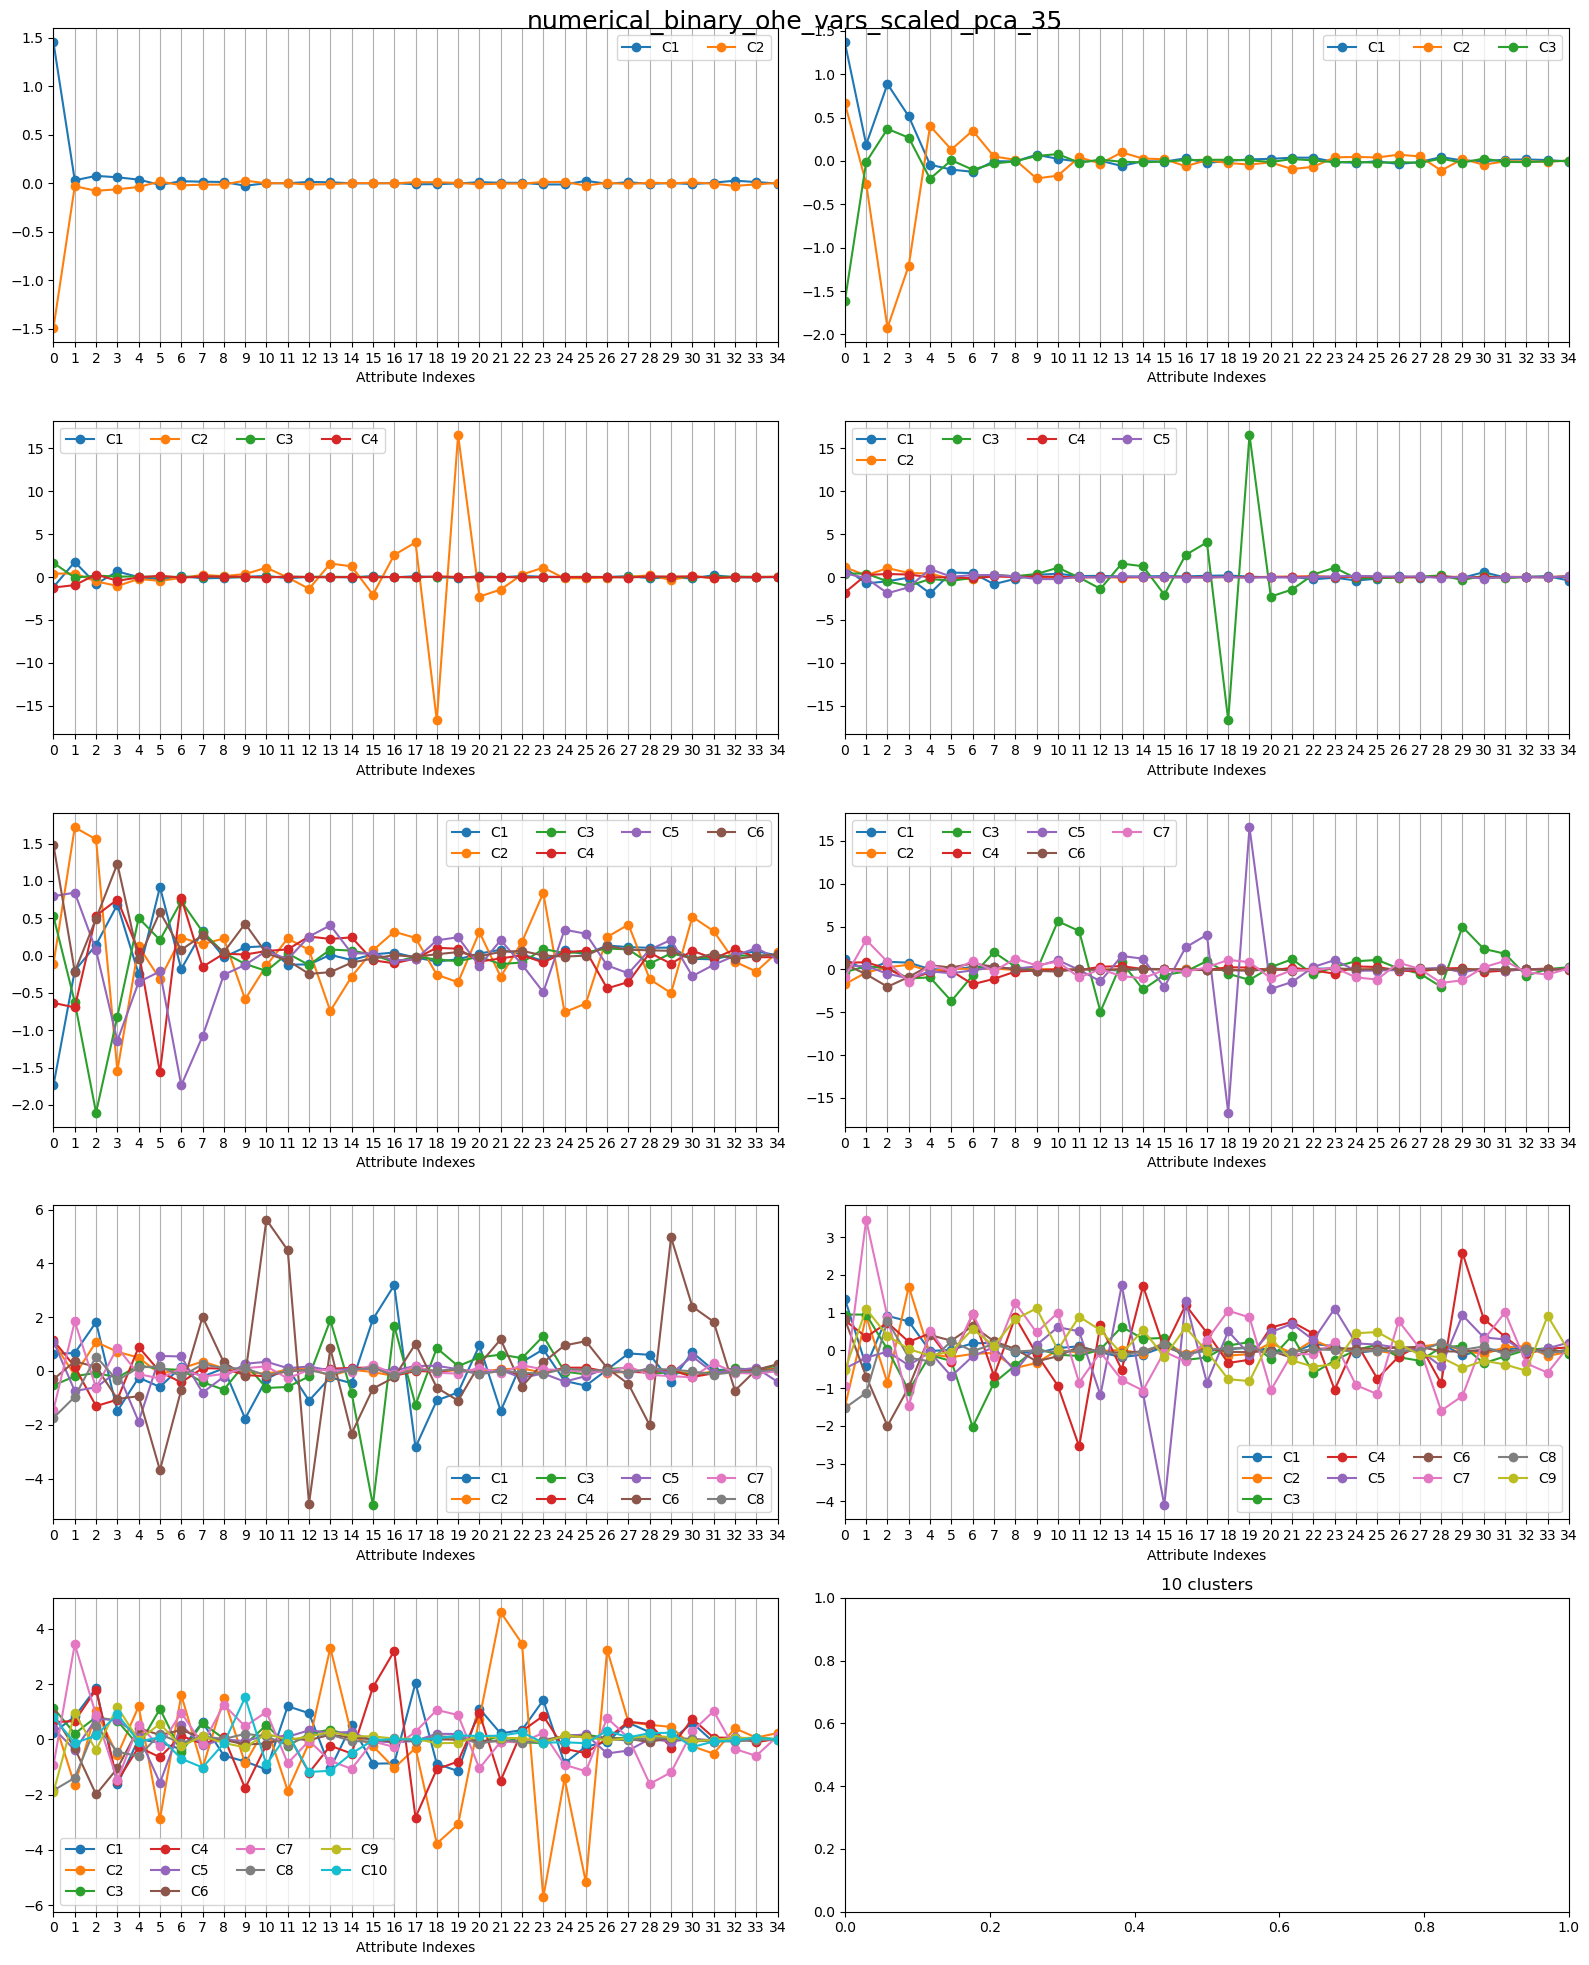

In [82]:
kmeans_model_selection(train, "numerical_binary_ohe_vars_scaled_pca_35")

### PCA: Visualization

With this data set, the visualization with only two components is not helpful because they explain only a tiny percentage of the overall variance.

In [83]:
train = train.withColumn("numerical_binary_ohe_vars_scaled_pca_2",
                         F.slice(vector_to_array("numerical_binary_ohe_vars_scaled_pca_full"), 1, 2))
test= test.withColumn("numerical_binary_ohe_vars_scaled_pca_2",
                      F.slice(vector_to_array("numerical_binary_ohe_vars_scaled_pca_full"), 1, 2))

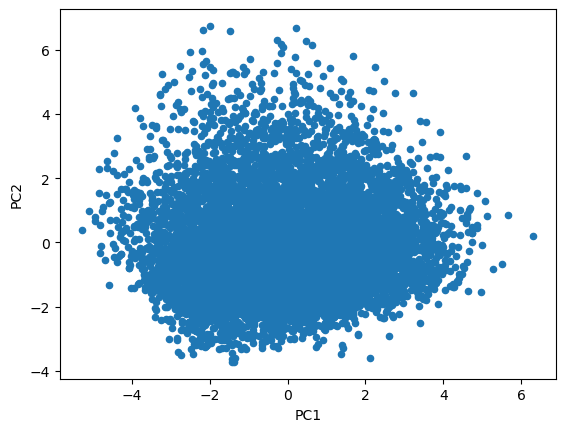

In [84]:
# Take a sample of 1% a draw a scatter plot with 2 components

sample_df = train.sample(fraction=0.01, seed=42).select("numerical_binary_ohe_vars_scaled_pca_2")
sample_df = pd.DataFrame(sample_df.toPandas()["numerical_binary_ohe_vars_scaled_pca_2"].tolist(), 
                         columns=["PC1", "PC2"])
sample_df.plot.scatter(x="PC1", y="PC2")

plt.show()

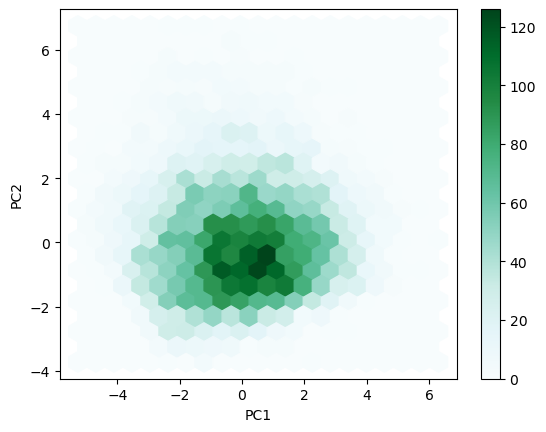

In [85]:
# hexbin plot with 2 components

sample_df.plot.hexbin(x="PC1", y="PC2", gridsize=20)
plt.show()

### PCA on the binary variables only

In [86]:
# Pipeline

# Scale binary and ohe variables
scaler = StandardScaler(withMean=True, inputCol="binary_ohe_vars",
                        outputCol="binary_ohe_vars_scaled")

# Apply PCA only on the binary and ohe variables
pca = PCA(k=train.schema["binary_ohe_vars"].metadata["ml_attr"]["num_attrs"], 
          inputCol="binary_ohe_vars_scaled", outputCol="binary_ohe_vars_scaled_pca")

# Create a unique vector using numerical variables and the PCA vector
assembler = VectorAssembler(inputCols=["numerical_vars_scaled", "binary_ohe_vars_scaled_pca"],
                            outputCol="numerical_binaryOhePCA_vars_scaled")


pipeline_stages = [scaler, pca, assembler]
pipeline_model = Pipeline(stages=pipeline_stages).fit(train)
train = pipeline_model.transform(train)
test = pipeline_model.transform(test)

In [87]:
pipeline_model.stages

[StandardScalerModel: uid=StandardScaler_f67615a2444b, numFeatures=27, withMean=true, withStd=true,
 PCAModel: uid=PCA_00f4852770e2, k=27,
 VectorAssembler_23e0b5fa4c40]

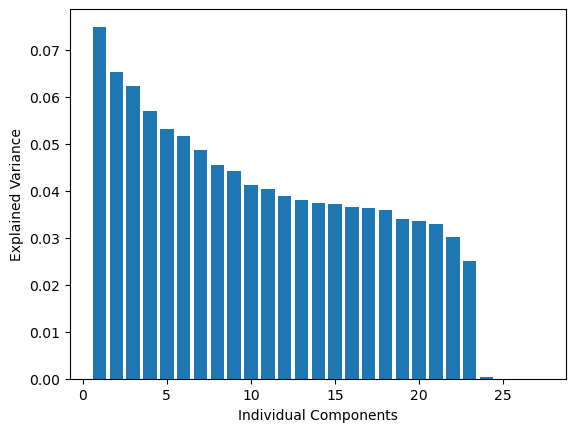

In [88]:
# Explained variance by single components

n = pipeline_model.stages[1].getK()
expl_variance = pipeline_model.stages[1].explainedVariance
plt.bar(range(1,n+1), expl_variance)
plt.ylabel("Explained Variance")
plt.xlabel("Individual Components")
plt.show()

In [89]:
n

27

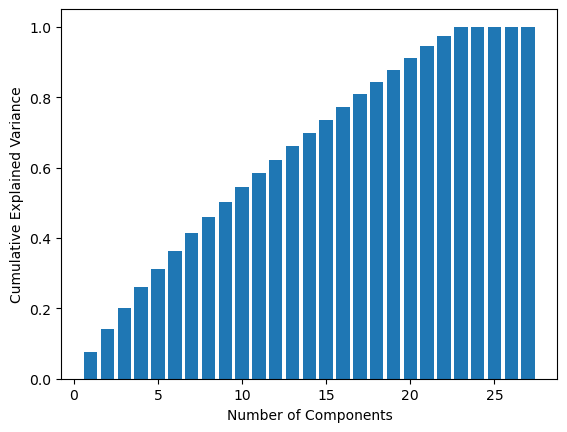

In [90]:
# cumulative explained variance

plt.bar(range(1,n+1), list(accumulate(expl_variance)))
plt.ylabel("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.show()

The first 23 components explains about 100% of the variance

k = 2, SSE = 33473039.93448093, Silhouette = 0.09481911868646144
k = 3, SSE = 32709067.999729298, Silhouette = 0.10187628759196157
k = 4, SSE = 31731097.60427387, Silhouette = 0.08543595250480329
k = 5, SSE = 30960841.518984728, Silhouette = 0.10386340138746258
k = 6, SSE = 29711664.69208681, Silhouette = 0.10899452384962072
k = 7, SSE = 29019922.10828001, Silhouette = 0.08130653799074186
k = 8, SSE = 28192061.696668305, Silhouette = 0.11776751438362608
k = 9, SSE = 27946590.380042005, Silhouette = 0.11469738320502433
k = 10, SSE = 27013832.517151766, Silhouette = 0.11732831922568887


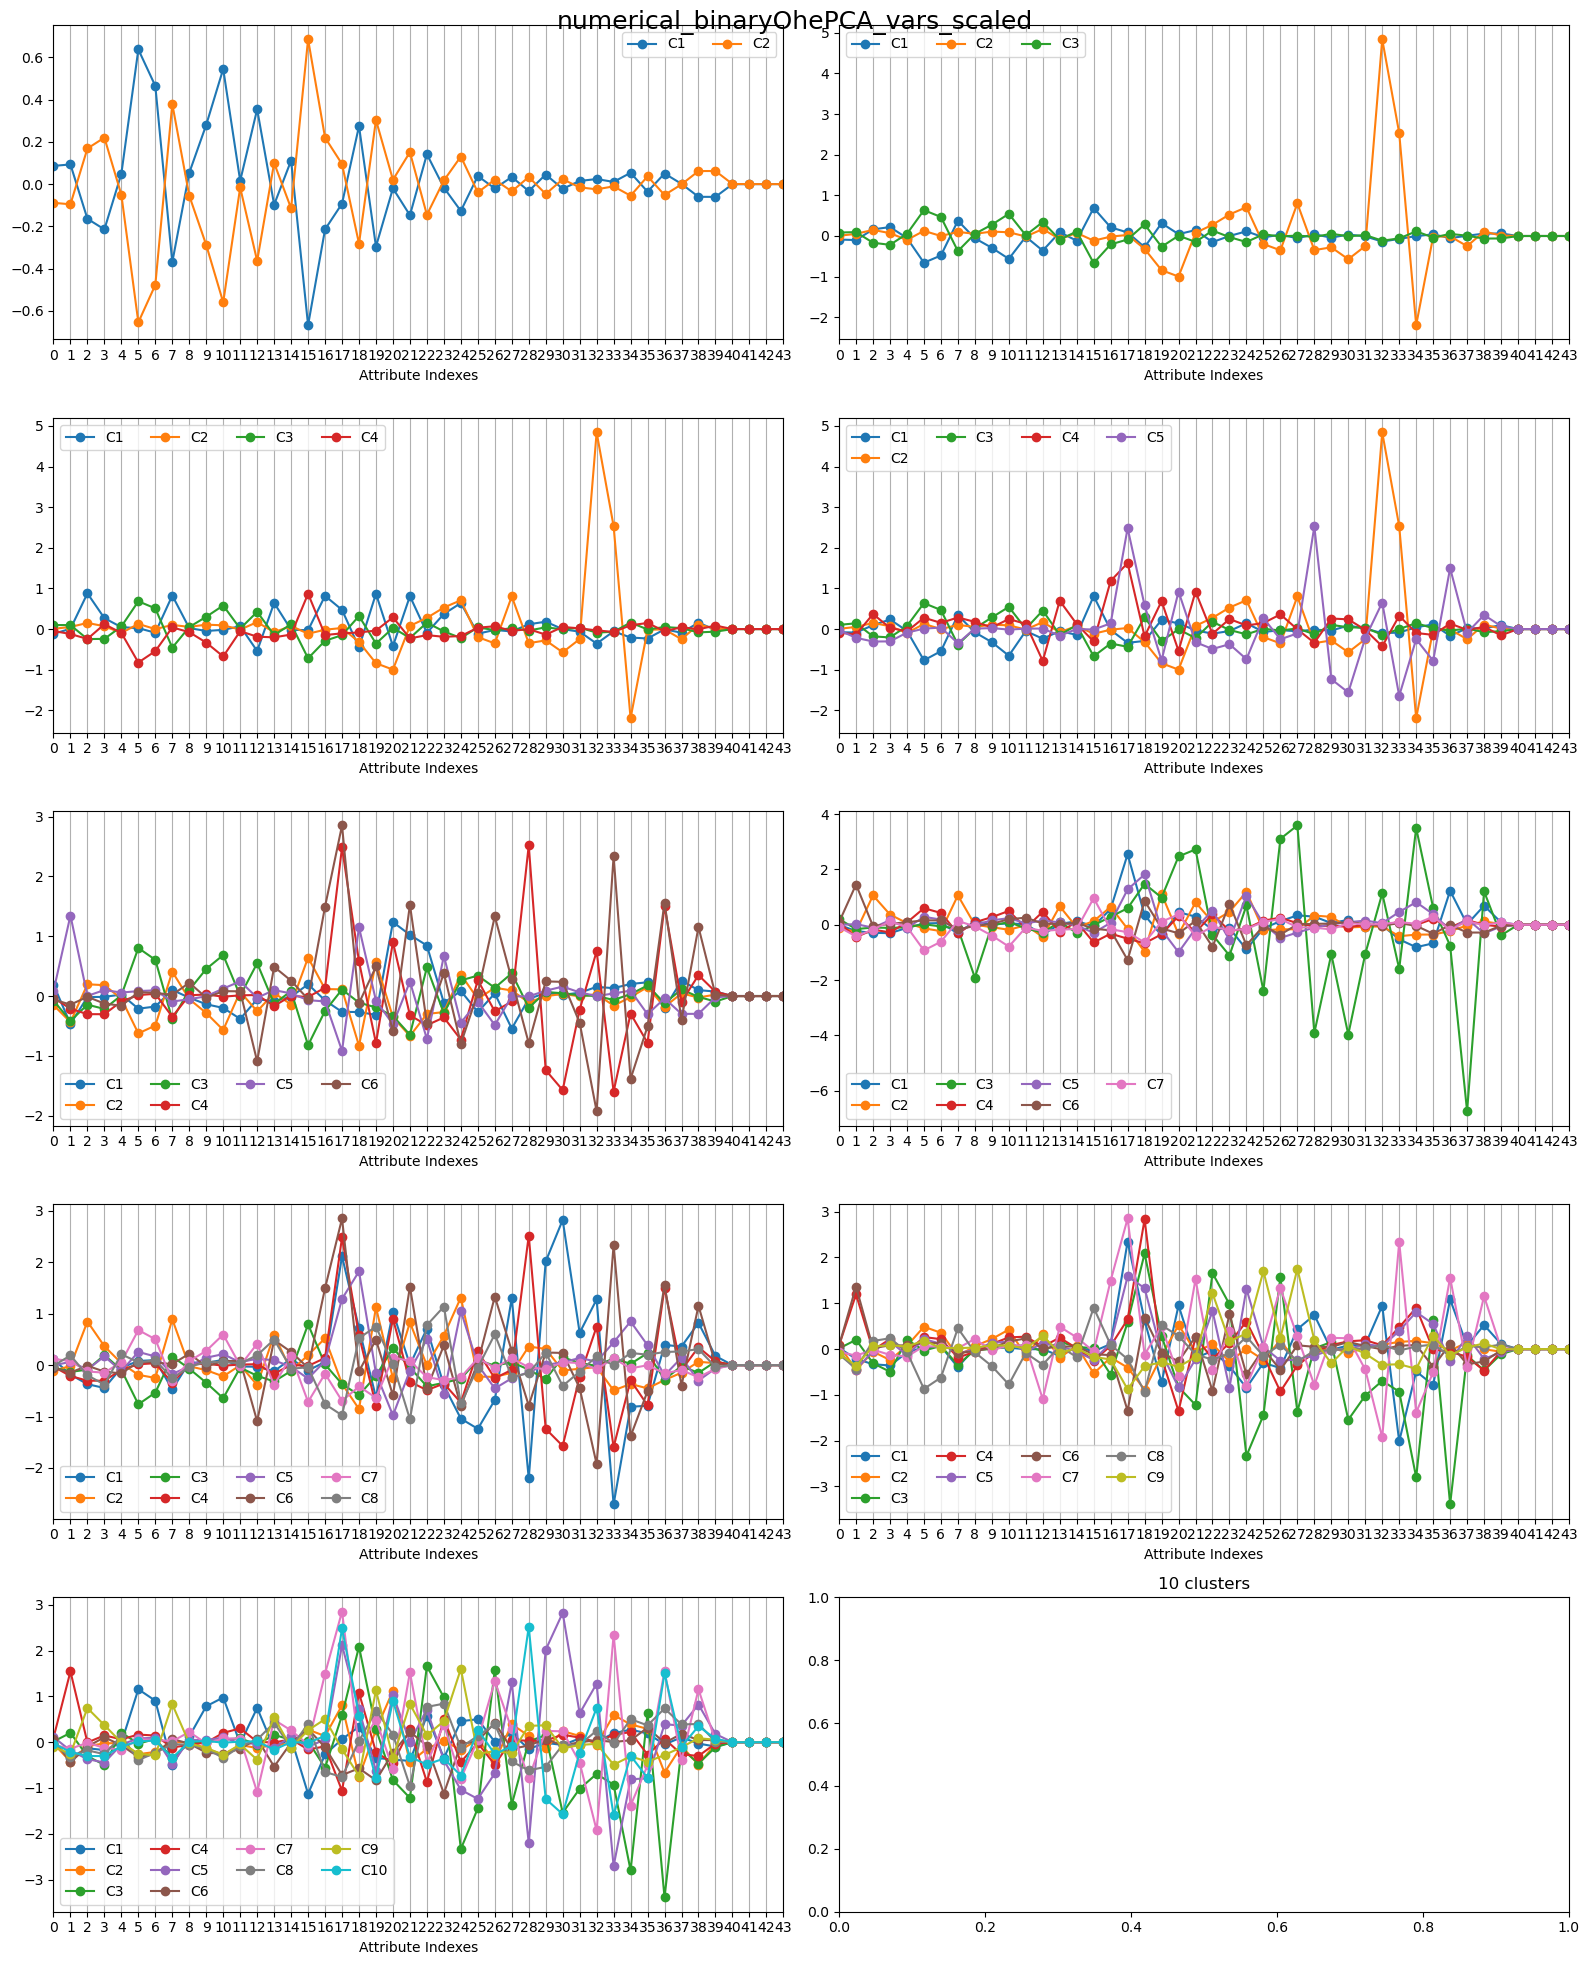

In [91]:
kmeans_model_selection(train, "numerical_binaryOhePCA_vars_scaled")

In [92]:
train.schema["numerical_binaryOhePCA_vars_scaled"].metadata

{'ml_attr': {'attrs': {'numeric': [{'idx': 0,
     'name': 'numerical_vars_scaled_0'},
    {'idx': 1, 'name': 'numerical_vars_scaled_1'},
    {'idx': 2, 'name': 'numerical_vars_scaled_2'},
    {'idx': 3, 'name': 'numerical_vars_scaled_3'},
    {'idx': 4, 'name': 'numerical_vars_scaled_4'},
    {'idx': 5, 'name': 'numerical_vars_scaled_5'},
    {'idx': 6, 'name': 'numerical_vars_scaled_6'},
    {'idx': 7, 'name': 'numerical_vars_scaled_7'},
    {'idx': 8, 'name': 'numerical_vars_scaled_8'},
    {'idx': 9, 'name': 'numerical_vars_scaled_9'},
    {'idx': 10, 'name': 'numerical_vars_scaled_10'},
    {'idx': 11, 'name': 'numerical_vars_scaled_11'},
    {'idx': 12, 'name': 'numerical_vars_scaled_12'},
    {'idx': 13, 'name': 'numerical_vars_scaled_13'},
    {'idx': 14, 'name': 'numerical_vars_scaled_14'},
    {'idx': 15, 'name': 'numerical_vars_scaled_15'},
    {'idx': 16, 'name': 'numerical_vars_scaled_16'},
    {'idx': 17, 'name': 'binary_ohe_vars_scaled_pca_0'},
    {'idx': 18, 'name': 'b

In [93]:
# Let's remove the last 4 components

train = train.withColumn("numerical_binaryOhePCA_vars_scaled_40",
                         F.slice(vector_to_array("numerical_binaryOhePCA_vars_scaled"), 1, 40))
test= test.withColumn("numerical_binaryOhePCA_vars_scaled_40",
                      F.slice(vector_to_array("numerical_binaryOhePCA_vars_scaled"), 1, 40))

k = 2, SSE = 33463387.5432833, Silhouette = 0.09485072079730641
k = 3, SSE = 33288584.969947696, Silhouette = 0.2507885075582623
k = 4, SSE = 31721658.975133568, Silhouette = 0.08550949949436236
k = 5, SSE = 30899798.300282948, Silhouette = 0.05404208419034561
k = 6, SSE = 29727309.23006326, Silhouette = 0.10777107286578162
k = 7, SSE = 29010765.516696204, Silhouette = 0.08136853797708313
k = 8, SSE = 28392067.715640336, Silhouette = 0.10493879604994823
k = 9, SSE = 27497565.612411432, Silhouette = 0.11703608614819835
k = 10, SSE = 27054424.30925576, Silhouette = 0.11243193259125897


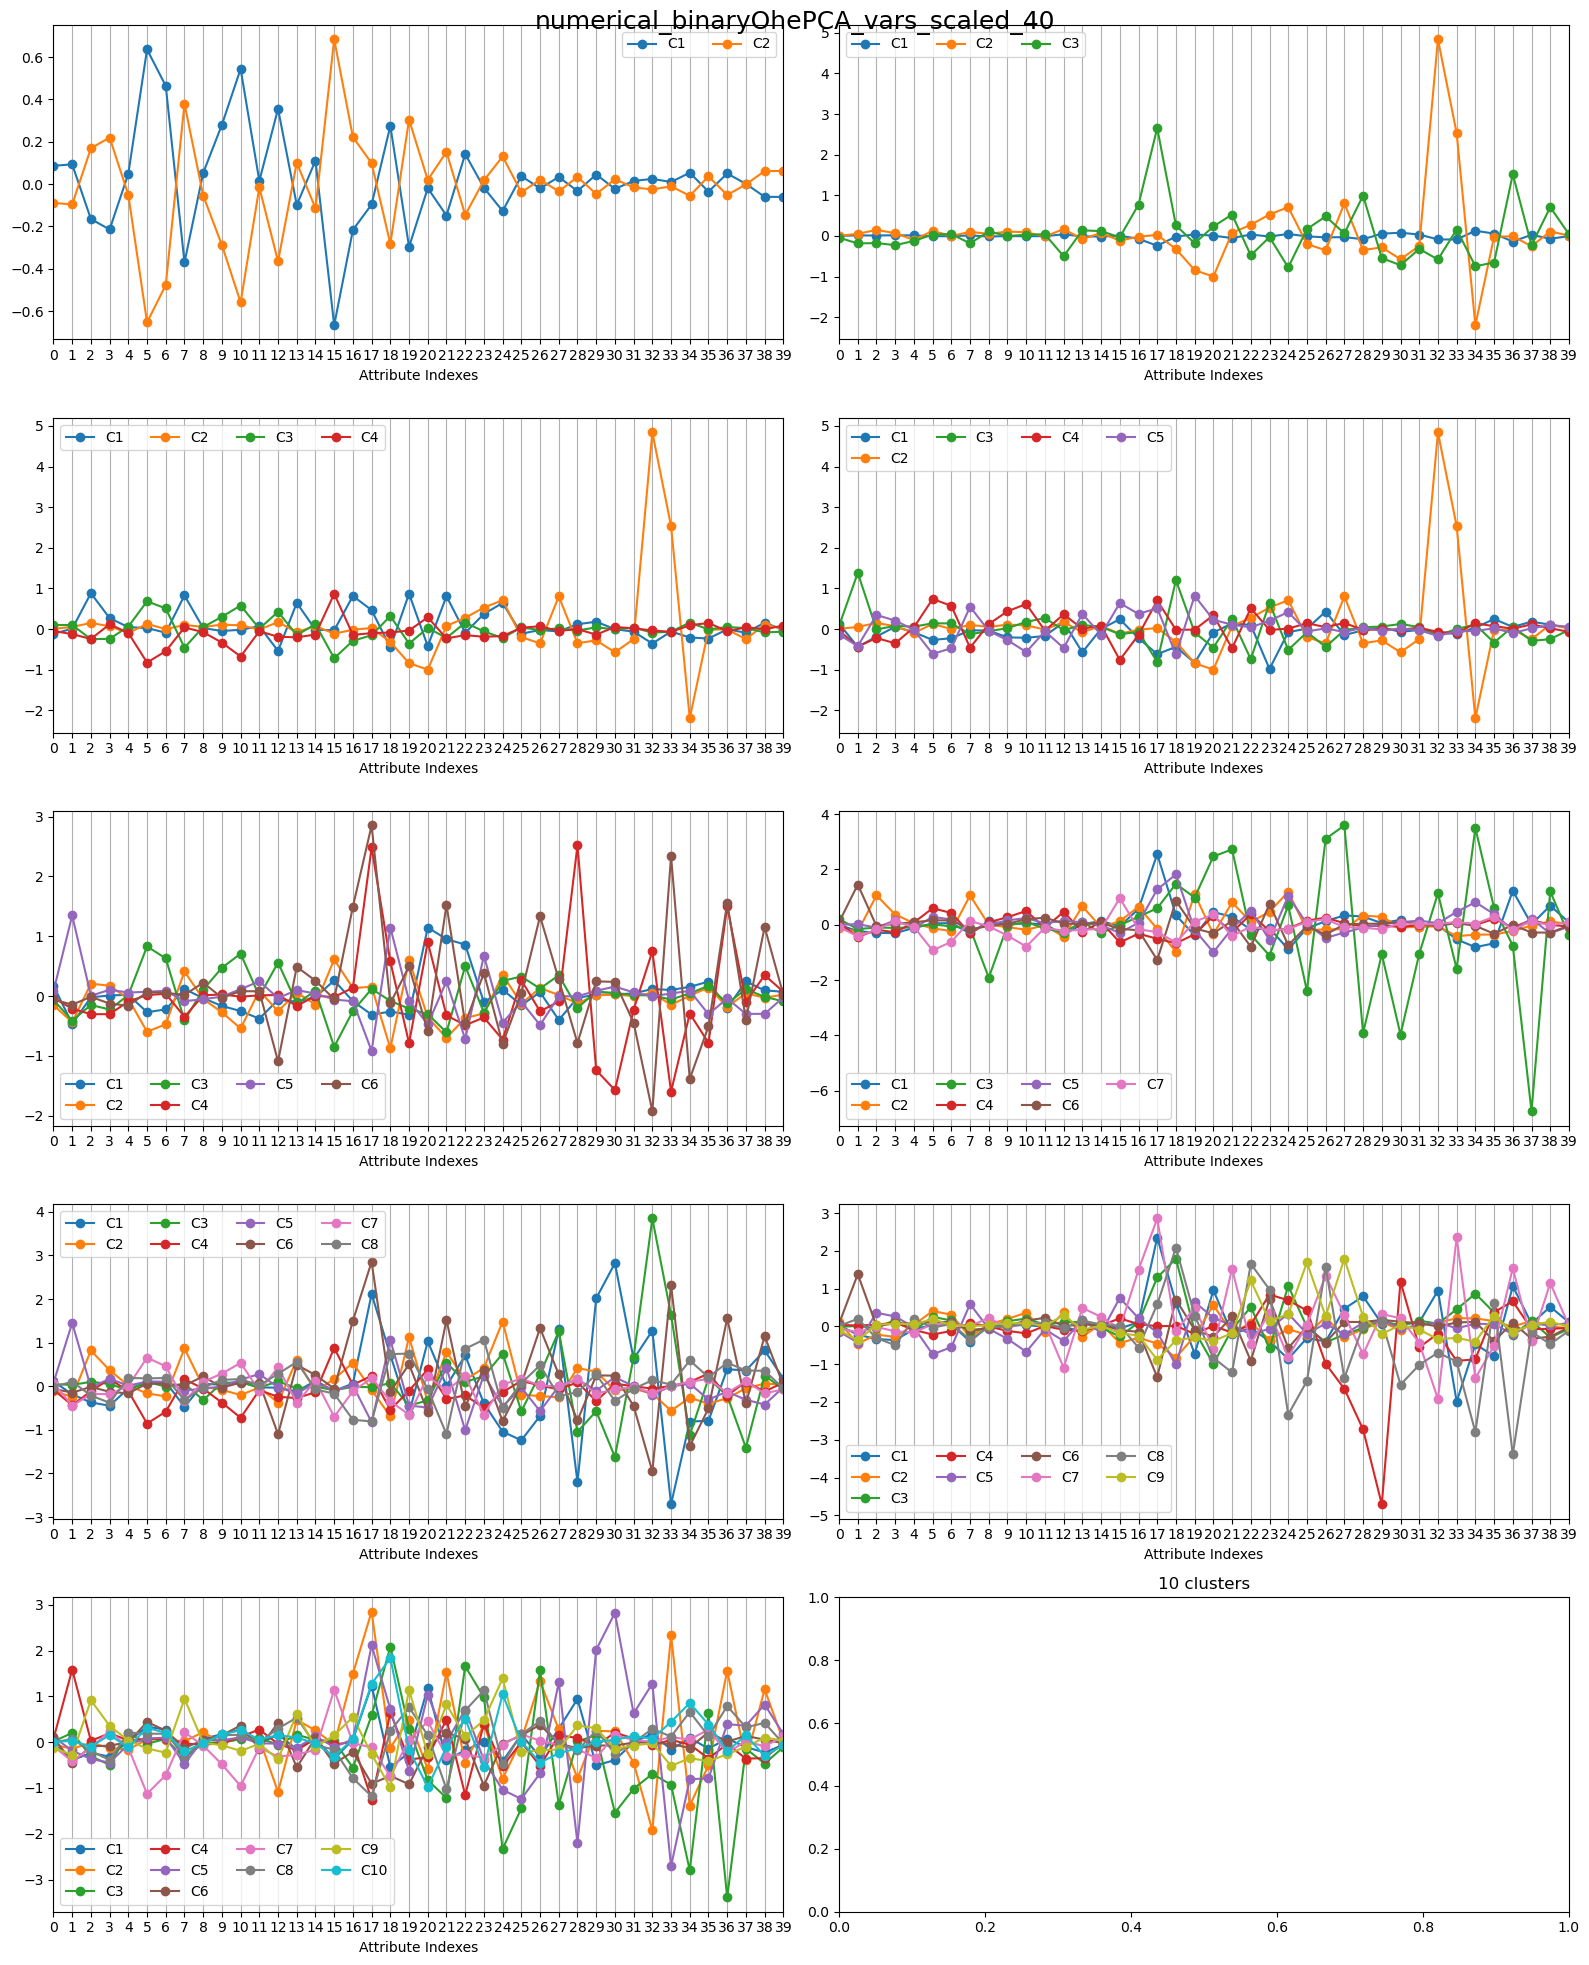

In [94]:
kmeans_model_selection(train, "numerical_binaryOhePCA_vars_scaled_40")

## Improve clustering

We now focus on the `numerical_binaryOhePCA_vars_scaled_40` feature vector. The aim is to compare different clustering algorithms with each other, also testing different parameters.

In [95]:
feature = "numerical_binaryOhePCA_vars_scaled_40"

### Kmeans

In [96]:
kmeans = KMeans(featuresCol=feature, k=6,
                initSteps=10, tol=1e-6, maxIter=50, seed=42)
kmeans_model = kmeans.fit(train)

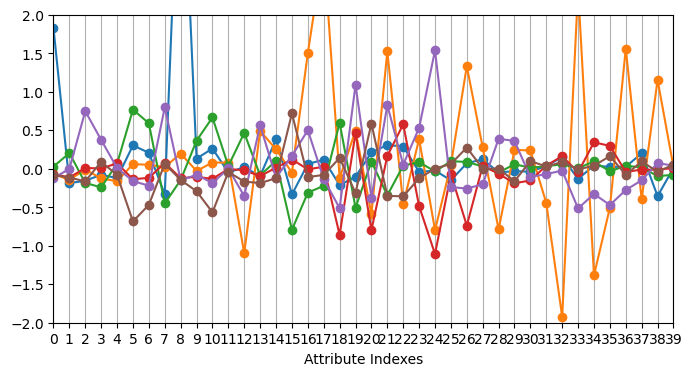

In [97]:
fig, ax = plt.subplots(figsize=(8,4))
plot_centroids(kmeans_model.clusterCenters(), title=False, ax=ax)
ax.set_ylim(-2, 2)
plt.show()

In [98]:
clustering_evaluation([(_, kmeans_model)], feature).show()

+---+---------+-------------+----------+
|  k| distance|          SSE|silhouette|
+---+---------+-------------+----------+
|  6|euclidean|3.042393475E7|     0.084|
+---+---------+-------------+----------+



In [100]:
# Test cosine distance

kmeans = KMeans(featuresCol=feature, initSteps=5, maxIter=10, seed=42)
params = [{kmeans.k: n, kmeans.distanceMeasure: "cosine"} for n in range(2, 11)]
kmeans_models = kmeans.fitMultiple(train, params)

# Evaluate clustering
kmeans_res = clustering_evaluation(kmeans_models, feature)
kmeans_res.show()

+---+--------+----------+----------+
|  k|distance|       SSE|silhouette|
+---+--------+----------+----------+
|  2|  cosine|609032.902|     0.095|
|  3|  cosine|563330.139|     0.074|
|  4|  cosine|527242.942|     0.058|
|  5|  cosine|503885.583|      0.08|
|  6|  cosine|474409.745|     0.064|
|  7|  cosine|457592.483|     0.069|
|  8|  cosine|  452145.8|     0.075|
|  9|  cosine|440985.259|       0.1|
| 10|  cosine|419756.974|     0.077|
+---+--------+----------+----------+



### Bisecting K-means

In [101]:
# Instantiate and fit bisecting kmeans
bkmeans = BisectingKMeans(featuresCol=feature, maxIter=10, seed=42)
params = [
    *[{bkmeans.k: n, bkmeans.distanceMeasure: "euclidean"} for n in range(2, 11)],
    *[{bkmeans.k: n, bkmeans.distanceMeasure: "cosine"} for n in range(2, 11)]
]
bkmeans_models = bkmeans.fitMultiple(train, params)

# Evaluate clustering
bkmeans_res = clustering_evaluation(bkmeans_models, feature)
bkmeans_res.show()

+---+---------+--------------+----------+
|  k| distance|           SSE|silhouette|
+---+---------+--------------+----------+
|  2|euclidean|3.3494989966E7|     0.096|
|  3|euclidean|3.2281493918E7|     0.064|
|  4|euclidean|3.1632472555E7|      0.08|
|  5|euclidean|3.1209375255E7|     0.048|
|  6|euclidean|3.0750205464E7|     0.052|
|  7|euclidean|3.0409445813E7|     0.053|
|  8|euclidean|2.9661097744E7|     0.072|
|  9|euclidean|2.9338571334E7|     0.068|
| 10|euclidean|2.8945715195E7|     0.071|
|  2|   cosine|     609025.37|     0.095|
|  3|   cosine|    572181.556|     0.089|
|  4|   cosine|    536927.352|     0.067|
|  5|   cosine|    519401.662|     0.033|
|  6|   cosine|    508201.668|     0.031|
|  7|   cosine|    485049.349|     0.042|
|  8|   cosine|    473520.584|     0.051|
|  9|   cosine|    464521.921|     0.037|
| 10|   cosine|    452712.417|     0.039|
+---+---------+--------------+----------+



### Gaussian Mixture Model

In [103]:
# # Instantiate and fit the model
# gmm = GaussianMixture(featuresCol=feature, tol=0.0001, seed=42)
# params = [{gmm.k: n} for n in range(2, 6)]
# gmm_models = gmm.fitMultiple(train, params)

# # Evaluate clustering
# results = []
# for _, model in gmm_models:
#     k = model.getK()
#     ll = model.summary.logLikelihood
#     evaluator = ClusteringEvaluator(featuresCol=feature)
#     silh = evaluator.evaluate(model.summary.predictions)
#     results.append((k, round(ll, 3), round(silh, 3)))

# schema = ["k", "logLikelihood", "silhouette"]
# gmm_res = spark.createDataFrame(results, schema=schema)    
# gmm_res.show()

---

In [104]:
train = kmeans_model.transform(train)
test = kmeans_model.transform(test)

In [105]:
train = train.withColumnRenamed("prediction", "claster_label")
test = test.withColumnRenamed("prediction", "claster_label")

In [107]:
# Save train and test sets

# train.write.option("header", True).parquet(path="train_post_clustering")
# test.write.option("header", True).parquet(path="test_post_clustering")

## Clustering characterization

In [109]:
# train = spark.read.option("header", True).parquet("train_post_clustering")
# test = spark.read.option("header", True).parquet("test_post_clustering")

In [110]:
res = kmeans_model.summary.predictions
res.createOrReplaceTempView("res")

In [111]:
# Size of clusters
var_distribution(res, "prediction").show()

+----------+------+--------+
|prediction| Count|Count(%)|
+----------+------+--------+
|         2|253608|   31.69|
|         5|241665|    30.2|
|         3|134987|   16.87|
|         4|118869|   14.85|
|         1| 30071|    3.76|
|         0| 21075|    2.63|
+----------+------+--------+



The clustering is very unbalanced

In [112]:
# Distribution of the target variable inside clusters

spark.sql("""
    SELECT 
        *,
        ROUND(fraud_bool_0 / count * 100, 3) AS fraud_bool_0_percentage,
        ROUND(fraud_bool_1 / count * 100, 3) AS fraud_bool_1_percentage
    FROM (
        SELECT 
            prediction AS cluster_label,
            COUNT(fraud_bool) AS count,
            SUM(CASE WHEN fraud_bool = 0 then 1 else 0 end) AS fraud_bool_0,
            SUM(CASE WHEN fraud_bool = 1 then 1 else 0 end) AS fraud_bool_1
        FROM res
        GROUP BY prediction
    )
    SORT BY fraud_bool_1_percentage DESC
""").show()

+-------------+------+------------+------------+-----------------------+-----------------------+
|cluster_label| count|fraud_bool_0|fraud_bool_1|fraud_bool_0_percentage|fraud_bool_1_percentage|
+-------------+------+------------+------------+-----------------------+-----------------------+
|            4|118869|      114689|        4180|                 96.484|                  3.516|
|            0| 21075|       20353|         722|                 96.574|                  3.426|
|            1| 30071|       29302|         769|                 97.443|                  2.557|
|            3|134987|      133457|        1530|                 98.867|                  1.133|
|            5|241665|      240869|         796|                 99.671|                  0.329|
|            2|253608|      252777|         831|                 99.672|                  0.328|
+-------------+------+------------+------------+-----------------------+-----------------------+



About 50% (0 and 1 groups) of records have a very small percentage to be labeled as fraud. We can use this information in the classification task.

In [113]:
# Distribution of nominal variables within clusters

for var in vars_by_types["nominal_vars"]:
    print(var)
    tmp = res.groupby("prediction").pivot(var).count().fillna(0)
    tmp = tmp.withColumn("total", sum([F.col(c) for c in tmp.columns]))
    tmp = tmp.select("prediction", 
                     *[F.round((F.col(c)/F.col("total")*100), 3).alias(c + "(%)") 
                       for c in tmp.columns if c not in {"prediction", "total"}]).show()

del tmp

payment_type
+----------+------+------+------+------+-----+
|prediction| AA(%)| AB(%)| AC(%)| AD(%)|AE(%)|
+----------+------+------+------+------+-----+
|         1|18.915|46.532| 26.51| 8.017|0.023|
|         3|18.926|45.679|23.054|12.312|0.027|
|         5|20.603|41.723|28.651| 8.997|0.024|
|         4|21.991|41.007|25.754|11.218|0.027|
|         2|37.789|25.578|21.466|15.133|0.034|
|         0|16.541|30.804|39.891|12.716|0.047|
+----------+------+------+------+------+-----+

employment_status
+----------+------+------+------+-----+-----+-----+-----+
|prediction| CA(%)| CB(%)| CC(%)|CD(%)|CE(%)|CF(%)|CG(%)|
+----------+------+------+------+-----+-----+-----+-----+
|         1|   0.0|   0.0|99.997|  0.0|  0.0|  0.0|  0.0|
|         3|80.157|10.533|   0.0|2.782|2.802|3.676|0.048|
|         5|79.119| 9.749|   0.0|2.714|2.013|6.356|0.046|
|         4|  82.1|15.415|   0.0|0.659|0.455|1.321|0.047|
|         2|67.762|20.399|   0.0|3.598|3.337| 4.86|0.044|
|         0| 74.41|12.683| 0.712| 

In [114]:
# Distribution of binary variables within clusters

for var in vars_by_types["binary_vars"]:
    print(var)
    tmp = res.groupby("prediction").pivot(var).count().fillna(0)
    tmp = tmp.withColumn("total", sum([F.col(c) for c in tmp.columns]))
    tmp = tmp.select("prediction", 
                     *[F.round((F.col(c)/F.col("total")*100), 3).alias(c + "(%)") 
                       for c in tmp.columns if c not in {"prediction", "total"}]).show()

del tmp

keep_alive_session
+----------+------+------+
|prediction|  0(%)|  1(%)|
+----------+------+------+
|         1| 55.48|44.516|
|         3|42.736|57.262|
|         5|39.933|60.065|
|         4|49.177| 50.82|
|         2|37.842|62.157|
|         0|63.507|36.493|
+----------+------+------+

email_is_free
+----------+------+------+
|prediction|  0(%)|  1(%)|
+----------+------+------+
|         1|47.975|52.022|
|         3|46.695|53.303|
|         5|49.013|50.985|
|         4|54.665|45.332|
|         2|41.687|58.312|
|         0|45.836|54.164|
+----------+------+------+

has_other_cards
+----------+------+------+
|prediction|  0(%)|  1(%)|
+----------+------+------+
|         1|73.264|26.733|
|         3|80.224|19.774|
|         5|73.717|26.281|
|         4|72.348|27.649|
|         2|82.579| 17.42|
|         0|85.163|14.837|
+----------+------+------+

foreign_request
+----------+------+-----+
|prediction|  0(%)| 1(%)|
+----------+------+-----+
|         1|97.898|2.098|
|         3|97.343

In [115]:
# Discretize numerical variables and compute their distribution within clusters

for var in vars_by_types["numerical_vars"]:
    print(var)
    output_name = var + "_discretized"
    discretizer = QuantileDiscretizer(
        numBuckets=5, inputCol=var, outputCol=output_name
    )
    tmp = discretizer.fit(res).transform(res)
    tmp = tmp.select(
        "prediction",
        F.concat(
            F.lit("quantile_"), 
            (F.col(output_name) + 1.0).cast(IntegerType()).cast(StringType())
        ).alias(output_name)
    )
    tmp = tmp.groupby("prediction").pivot(output_name).count().fillna(0)
    tmp = tmp.withColumn("total", sum([F.col(c) for c in tmp.columns]))
    tmp = tmp.select("prediction", 
                     *[F.round((F.col(c)/F.col("total")*100), 3).alias(c + "(%)") 
                       for c in tmp.columns if c not in {"prediction", "total"}]).show()

del tmp

days_since_request
+----------+-------------+-------------+-------------+-------------+-------------+
|prediction|quantile_1(%)|quantile_2(%)|quantile_3(%)|quantile_4(%)|quantile_5(%)|
+----------+-------------+-------------+-------------+-------------+-------------+
|         1|       16.557|       17.169|       18.835|        22.03|       25.406|
|         3|       20.688|       20.556|        20.45|       20.058|       18.246|
|         5|        19.71|        20.03|       20.416|       21.361|       18.481|
|         4|       22.142|       21.589|       21.133|       20.096|       15.035|
|         2|       19.495|       19.437|       19.288|       18.782|       22.997|
|         0|       17.438|       17.001|       15.502|       15.089|        34.97|
+----------+-------------+-------------+-------------+-------------+-------------+

intended_balcon_amount
+----------+-------------+-------------+-------------+-------------+-------------+
|prediction|quantile_1(%)|quantile_2(%)|quan

# Classification

In [116]:
# Custom functions

def evaluate_classifier(summary):
    methods = ["fMeasureByLabel", "weightedFMeasure"]
    attributes = ["accuracy", "precisionByLabel", "recallByLabel", 
                  "weightedPrecision", "weightedRecall", "areaUnderROC",
                  "truePositiveRateByLabel", "falsePositiveRateByLabel", 
                  "weightedTruePositiveRate", "weightedFalsePositiveRate"]
    
    res = []
    for method in methods:
        if hasattr(summary, method):
            value = getattr(summary, method)()
            if isinstance(value, list):
                value = [round(x, 4) for x in value]
            else:
                value = round(value, 4)
            res.append((method, value))
    for attribute in attributes:
        if hasattr(summary, attribute):
            value = getattr(summary, attribute)
            if isinstance(value, list):
                value = [round(x, 4) for x in value]
            else:
                value = round(value, 4)        
            res.append((attribute, value))
    
    return pd.DataFrame(res, columns=["measure", "value"])

def plot_curve(summary, curve: "[roc | pr]", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    if hasattr(summary, curve):
        x = []
        y = []
        for row in getattr(summary, curve).collect():
            x.append(row[0])
            y.append(row[1])
        ax.plot(x,y)
        if curve == "roc":
            xlabel = "FPR"
            ylabel = "TPR"
            ax.plot([0,1], [0,1], "k--")
        else:
            xlabel = "Recall"
            ylabel = "Precision"
        ax.set_xlabel(f"{xlabel}")
        ax.set_ylabel(f"{ylabel}")
        return ax
    print(f"Attribute {curve} not found")
    
def get_model_params(params: list[dict], index: int) -> dict:
    """
    To be used with CrossValidatorModel. Given the list of parameters produced
    by ParamGridBuilder and an index (retrived, for instance, by the 
    output of the avgMetrics() method) return the user-defined parameters.
    """
    res = {}
    for param, value in params[index].items():
        res[param.name] = value
    return res

def plot_confusion_matrix(cm: np.ndarray, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(3,3))
        ax = fig.add_subplot()
    sns.heatmap(cm, annot = True, fmt = '0', annot_kws = {"fontsize": 16}, 
                cmap = "Blues", cbar = False, ax = ax)
    ax.set_xlabel('Predicted Class', fontsize = 14)
    ax.set_ylabel('Actual Class', fontsize = 14)
    ax.set_xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
    ax.set_yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    return ax

def confusion_matrix(df:pysparkDF, 
                     labelCol: str = "fraud_bool", 
                     predictionCol: str = "prediction"):
    def cm(label, prediction):
        res = np.zeros(4, dtype=int)
        if label == prediction:
            if label:  # TP
                res[0] = 1
            else:  # TN
                res[3] = 1
        elif prediction:  # FP
            res[2] = 1
        else:  # FN
            res[1] = 1
        return res
    
    return df.rdd\
        .map(lambda row: cm(row[labelCol], row[predictionCol]))\
        .reduce(lambda arr1, arr2: arr1 + arr2).reshape((2,2))

## Feature selection

In [122]:
# load train and test sets

# train = spark.read.option("header", True).parquet("train_post_clustering")
# test = spark.read.option("header", True).parquet("test_post_clustering")

In [119]:
with open("vars_by_types", "rb") as f:
    vars_by_types = pickle.load(f)

In [120]:
# In addition to numerical, binary and ohe variables (all standardized), 
# we also consider the cluster labels. (features1)

to_be_assembled = ["numerical_binary_ohe_vars_scaled", "claster_label"]
assembler = VectorAssembler(inputCols=to_be_assembled, 
                            outputCol="features1")

train = assembler.transform(train)
test = assembler.transform(test)

In [121]:
# Let's compute a simple random forest and analyze its 
# feature importances to perform a feature selection

rnd_forest = RandomForestClassifier(featuresCol="features1", 
                                    labelCol="fraud_bool", 
                                    numTrees=100, 
                                    maxDepth=10, 
                                    featureSubsetStrategy="sqrt", 
                                    seed=42)

rnd_forest_model = rnd_forest.fit(train)

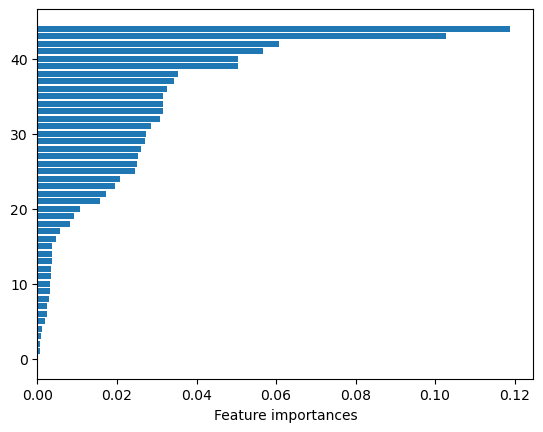

In [123]:
features_import = rnd_forest_model.featureImportances.toArray()
sorted_idexes = features_import.argsort().tolist()
n = len(features_import)
plt.barh(range(n), features_import[sorted_idexes])
plt.xlabel("Feature importances")
plt.show()

In [125]:
# Variables with an importance smaller than 1%

dct_all = feature_mapper(train, "numerical_binary_ohe_vars")
reverse_map = {v: k for k, v in dct_all.items()}
small_importances = np.where(features_import < 0.01)[0]
for idx in small_importances:
    print(dct_all[idx])

binary_ohe_vars_binary_vars_foreign_request
binary_ohe_vars_binary_vars_phone_mobile_valid
binary_ohe_vars_ohe_vars_payment_type_indexed_ohe_AB
binary_ohe_vars_ohe_vars_payment_type_indexed_ohe_AA
binary_ohe_vars_ohe_vars_payment_type_indexed_ohe_AD
binary_ohe_vars_ohe_vars_employment_status_indexed_ohe_CA
binary_ohe_vars_ohe_vars_employment_status_indexed_ohe_CB
binary_ohe_vars_ohe_vars_employment_status_indexed_ohe_CF
binary_ohe_vars_ohe_vars_employment_status_indexed_ohe_CC
binary_ohe_vars_ohe_vars_employment_status_indexed_ohe_CD
binary_ohe_vars_ohe_vars_employment_status_indexed_ohe_CE
binary_ohe_vars_ohe_vars_housing_status_indexed_ohe_BC
binary_ohe_vars_ohe_vars_housing_status_indexed_ohe_BB
binary_ohe_vars_ohe_vars_housing_status_indexed_ohe_BE
binary_ohe_vars_ohe_vars_housing_status_indexed_ohe_BD
binary_ohe_vars_ohe_vars_housing_status_indexed_ohe_BF
binary_ohe_vars_ohe_vars_source_indexed_ohe_INTERNET
binary_ohe_vars_ohe_vars_device_os_indexed_ohe_other
binary_ohe_vars_ohe_v

Note that they all are binary variables

In [127]:
# top 10 variables

# dct_all = feature_mapper(train, "numerical_binary_ohe_vars")
# for idx in sorted_idexes[-10:]:
#     print(dct_all[idx])

In [128]:
# Select top features according to chi2 (binary vars)

selector = UnivariateFeatureSelector(featuresCol="binary_ohe_vars_scaled", 
                                     labelCol="fraud_bool")
selector.setFeatureType("categorical")
selector.setLabelType("categorical")
selector.setSelectionThreshold(27)  
selector_model = selector.fit(train)

In [129]:
# number of binary attributes

train.schema["binary_ohe_vars_scaled"].metadata["ml_attr"]["num_attrs"]

27

In [130]:
# Ordered from high scores to small scores

dct_binary = feature_mapper(train, "binary_ohe_vars")
for idx in selector_model.selectedFeatures:
    print(dct_binary[idx])

binary_vars_keep_alive_session
binary_vars_email_is_free
binary_vars_has_other_cards
binary_vars_foreign_request
binary_vars_phone_mobile_valid
binary_vars_phone_home_valid
ohe_vars_payment_type_indexed_ohe_AA
ohe_vars_payment_type_indexed_ohe_AC
ohe_vars_employment_status_indexed_ohe_CA
ohe_vars_employment_status_indexed_ohe_CB
ohe_vars_employment_status_indexed_ohe_CF
ohe_vars_employment_status_indexed_ohe_CC
ohe_vars_employment_status_indexed_ohe_CD
ohe_vars_employment_status_indexed_ohe_CE
ohe_vars_housing_status_indexed_ohe_BC
ohe_vars_housing_status_indexed_ohe_BB
ohe_vars_housing_status_indexed_ohe_BA
ohe_vars_housing_status_indexed_ohe_BE
ohe_vars_device_os_indexed_ohe_other
ohe_vars_device_os_indexed_ohe_linux
ohe_vars_device_os_indexed_ohe_windows
ohe_vars_device_os_indexed_ohe_macintosh
ohe_vars_source_indexed_ohe_INTERNET
ohe_vars_housing_status_indexed_ohe_BD
ohe_vars_housing_status_indexed_ohe_BF
ohe_vars_payment_type_indexed_ohe_AB
ohe_vars_payment_type_indexed_ohe_AD


In [131]:
# If a variable is both in the worst 10 of its group 
# and has an importance smaller than 1%, then we remove it .

worst_10_banary = selector_model.selectedFeatures[-10:]
to_remove = []

for attr in worst_10_banary:
    var = "binary_ohe_vars_" + dct_binary[attr]
    if var in set(reverse_map.keys()):
        to_remove.append(var)

In [132]:
to_remove

['binary_ohe_vars_ohe_vars_housing_status_indexed_ohe_BE',
 'binary_ohe_vars_ohe_vars_device_os_indexed_ohe_other',
 'binary_ohe_vars_ohe_vars_device_os_indexed_ohe_linux',
 'binary_ohe_vars_ohe_vars_device_os_indexed_ohe_windows',
 'binary_ohe_vars_ohe_vars_device_os_indexed_ohe_macintosh',
 'binary_ohe_vars_ohe_vars_source_indexed_ohe_INTERNET',
 'binary_ohe_vars_ohe_vars_housing_status_indexed_ohe_BD',
 'binary_ohe_vars_ohe_vars_housing_status_indexed_ohe_BF',
 'binary_ohe_vars_ohe_vars_payment_type_indexed_ohe_AB',
 'binary_ohe_vars_ohe_vars_payment_type_indexed_ohe_AD']

In [133]:
# Select top features according to f-statistic (numerical vars)

selector = UnivariateFeatureSelector(featuresCol="numerical_vars_scaled", 
                                     labelCol="fraud_bool")
selector.setFeatureType("continuous")
selector.setLabelType("categorical")
selector.setSelectionThreshold(17)
selector_model = selector.fit(train)

In [134]:
# number of numerical attributes

train.schema["numerical_vars_scaled"].metadata["ml_attr"]["num_attrs"]

17

In [135]:
dct = feature_mapper(train, "numerical_vars")
for idx in selector_model.selectedFeatures:
    print(dct[idx])

intended_balcon_amount
proposed_credit_limit
income
name_email_similarity
velocity_4w
velocity_6h
credit_risk_score
device_distinct_emails_8w
velocity_24h
bank_branch_count_8w
date_of_birth_distinct_emails_4w
current_address_months_count
session_length_in_minutes
month
customer_age
zip_count_4w
days_since_request


In [136]:
# Remove the worst variables

idexes_to_remove = {reverse_map[c] for c in to_remove}
n = train.schema["features1"].metadata["ml_attr"]["num_attrs"]
slicer = VectorSlicer(inputCol="features1", outputCol="features", 
                      indices=[i for i in range(n) if i not in idexes_to_remove])

train = slicer.transform(train)
test = slicer.transform(test)

In [138]:
# save the new train and test sets

# train.write.option("header", True).parquet("train_features_selected", mode="overwrite")
# test.write.option("header", True).parquet("test_features_selected", mode="overwrite")

## Training on the unbalanced dataset

In [140]:
# train = spark.read.option("header", True).parquet("train_features_selected")
# test = spark.read.option("header", True).parquet("test_features_selected")

In [141]:
train = train.select("fraud_bool", "features")
test = test.select("fraud_bool", "features")

### Support Vector Machine

In [142]:
svm = LinearSVC(labelCol="fraud_bool", standardization=False)
params = ParamGridBuilder().addGrid(svm.regParam, [0, 1, 5, 15]).build()
cv = CrossValidator(estimator=svm, 
                    estimatorParamMaps=params, 
                    evaluator=BinaryClassificationEvaluator(
                        labelCol="fraud_bool",
                        metricName="areaUnderPR"
                    ),
                    numFolds=5,
                    seed=42,
                    parallelism=4)

In [143]:
cv_model = cv.fit(train)

In [145]:
# cv_model.write().save("svm_unbalanced")

In [146]:
best_svm = cv_model.bestModel
evaluator = cv_model.getEvaluator()
summary = best_svm.summary()  # Training Summary

In [147]:
best_svm.getRegParam()

0.0

In [148]:
# Average (cross folds) of the metric (by default areaUnderROC) of each model 

cv_model.avgMetrics

[0.0628050839079166,
 0.05872762025900733,
 0.061381623052201975,
 0.05038047171450298]

In [149]:
get_model_params(params, np.argmax(cv_model.avgMetrics))

{'regParam': 0.0}

### Random Forest

In [150]:
rnd_forest = RandomForestClassifier(labelCol="fraud_bool", maxDepth=15, seed=42)
params = ParamGridBuilder()\
    .addGrid(rnd_forest.numTrees, [50, 100, 150])\
    .build()
    
cv = CrossValidator(estimator=rnd_forest, 
                    estimatorParamMaps=params, 
                    evaluator=BinaryClassificationEvaluator(labelCol="fraud_bool"),
                    numFolds=5,
                    seed=42)

In [ ]:
cv_model = cv.fit(train)

In [ ]:
cv_model.write().save("rnd_forest_unbalanced")

In [ ]:
best_rnd_forest = cv_model.bestModel
evaluator = cv_model.getEvaluator()
summary = best_rnd_forest.summary

In [ ]:
cv_model.avgMetrics

In [ ]:
best_rnd_forest.getMaxDepth()

In [ ]:
best_rnd_forest.getNumTrees

### Multilayer perceptron

In [390]:
mlp = MultilayerPerceptronClassifier(labelCol="fraud_bool", layers=(35, 10, 2), seed=42)
params = ParamGridBuilder()\
    .addGrid(mlp.stepSize, [0.01, 0.3, 0.5])\
    .addGrid(mlp.solver, ["l-bfgs", "gd"])\
    .build()
    
cv = CrossValidator(estimator=mlp, 
                    estimatorParamMaps=params, 
                    evaluator=BinaryClassificationEvaluator(
                        labelCol="fraud_bool",
                        metricName="areaUnderPR"
                    ),
                    numFolds=3,
                    seed=42)

In [391]:
cv_model = cv.fit(train)

In [394]:
cv_model.write().save("mlp_unbalanced")

In [395]:
best_mlp = cv_model.bestModel
evaluator = cv_model.getEvaluator()
summary = best_mlp.summary()

In [396]:
cv_model.avgMetrics

[0.11475203699594237,
 0.016356024207558467,
 0.11474960650895573,
 0.01897667594727748,
 0.11463461426650622,
 0.023562212559033336]

In [404]:
get_model_params(params, np.argmax(cv_model.avgMetrics))

{'stepSize': 0.01, 'solver': 'l-bfgs'}

In [405]:
best_mlp.getLayers(),\
best_mlp.getMaxIter(),\
best_mlp.getSolver(),\
best_mlp.getStepSize()

([35, 10, 2], 100, 'l-bfgs', 0.01)

### Classifier comparison

In [53]:
svm = LinearSVC(labelCol="fraud_bool", regParam=0, 
                standardization=False)
svm_model = svm.fit(train)

In [54]:
svm_summary = svm_model.evaluate(test)
svm_cmtx = confusion_matrix(svm_summary.predictions)

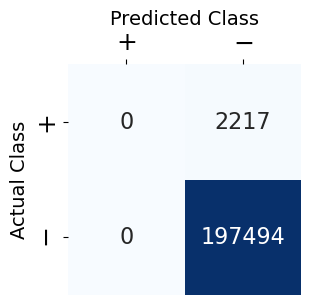

In [55]:
plot_confusion_matrix(svm_cmtx)
plt.show()

Note that also changing the reg parameter or setting incrising the number of iterations this it never predicts the positive class

In [56]:
rnd_forest = RandomForestClassifier(labelCol="fraud_bool", numTrees= 150, 
                                    maxDepth=15, seed=42)
rnd_forest_model = rnd_forest.fit(train)

In [57]:
rnd_forest_summary = rnd_forest_model.evaluate(test)
rnd_forest_cmtx = confusion_matrix(rnd_forest_summary.predictions)

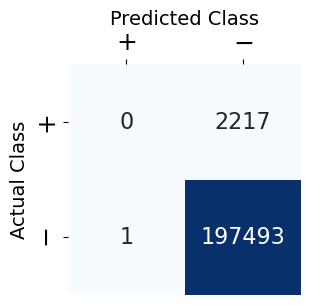

In [58]:
plot_confusion_matrix(rnd_forest_cmtx)
plt.show()

This classifier could be improved by modifying the threshold.

In [59]:
mlp = MultilayerPerceptronClassifier(labelCol="fraud_bool", layers=(35, 10, 2),
                                     maxIter=1000, stepSize=0.01,
                                     solver='l-bfgs', seed=42)
mlp_model = mlp.fit(train)

In [60]:
mlp_summary = mlp_model.evaluate(test)
mlp_cmtx = confusion_matrix(mlp_summary.predictions)

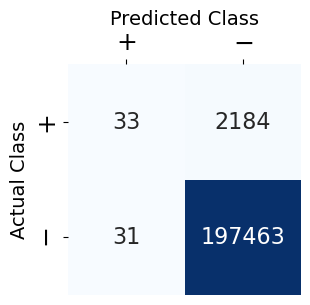

In [61]:
plot_confusion_matrix(mlp_cmtx)
plt.show()

---

In [62]:
svm_stats = evaluate_classifier(svm_summary)
rnd_forest_stats = evaluate_classifier(rnd_forest_summary)
mlp_stats = evaluate_classifier(mlp_summary)

In [63]:
svm_stats.merge(rnd_forest_stats, how="outer", on="measure")\
         .merge(mlp_stats, how="outer", on="measure")\
         .set_axis("measure svm rnd_forest mlp".split(), axis=1)

measure            svm     rnd_forest               mlp
0             fMeasureByLabel  [0.9944, 0.0]  [0.9944, 0.0]  [0.9944, 0.0289]
1            weightedFMeasure         0.9834         0.9834            0.9837
2                    accuracy         0.9889         0.9889            0.9889
3            precisionByLabel  [0.9889, 0.0]  [0.9889, 0.0]  [0.9891, 0.5156]
4               recallByLabel     [1.0, 0.0]     [1.0, 0.0]  [0.9998, 0.0149]
5           weightedPrecision         0.9779         0.9779            0.9838
6              weightedRecall         0.9889         0.9889            0.9889
7                areaUnderROC          0.763         0.8521               NaN
8     truePositiveRateByLabel     [1.0, 0.0]     [1.0, 0.0]  [0.9998, 0.0149]
9    falsePositiveRateByLabel     [1.0, 0.0]     [1.0, 0.0]  [0.9851, 0.0002]
10   weightedTruePositiveRate         0.9889         0.9889            0.9889
11  weightedFalsePositiveRate         0.9889         0.9889            0.9742

## Oversampling

Spark does not offer unbalanced learning algorithms. Moreover, there does not even seem to exist a distributed version of KNN, which is a subroutine for this type of algorithms. One strategy we can adopt is to perform a simple oversampling technique, but focusing on positive records that are difficult to classify.

In [191]:
var_distribution(train, "fraud_bool").show()

+----------+------+--------+
|fraud_bool| Count|Count(%)|
+----------+------+--------+
|         0|791477|    98.9|
|         1|  8812|     1.1|
+----------+------+--------+



In [231]:
# At each iteration duplicate only false negative predicted records. 
# Stop iterating when either the cardinality of the minority class 
# exceeds 400.000 or when the maximum number of iterations is reached.

cnt = 8812
max_sample = 400_000
maxiter = 20
i = 0

while cnt < max_sample and i < maxiter:
    logistic = LogisticRegression(labelCol="fraud_bool", standardization=False)
    logistic_model = logistic.fit(train)
    train2 = logistic_model.summary.predictions.where("fraud_bool=1 AND prediction=0")
    cnt += train2.count()    
    train2 = train2.drop("rawPrediction", "prediction", "probability")
    train = train.union(train2)
    i += 1

In [232]:
var_distribution(train, "fraud_bool").show()

+----------+------+--------+
|fraud_bool| Count|Count(%)|
+----------+------+--------+
|       0.0|791477|   58.06|
|       1.0|571704|   41.94|
+----------+------+--------+



In [257]:
# save the oversampled train set

train.write.option("header", True).parquet("train_oversampled", mode="overwrite")

---

In [64]:
# read train and test sets

train_os = spark.read.option("header", True).parquet("train_oversampled")
test = spark.read.option("header", True).parquet("test_features_selected")

In [65]:
train_os = train_os.select("fraud_bool", "features")
test = test.select("fraud_bool", "features")

In [9]:
train_os.printSchema()

root
 |-- fraud_bool: double (nullable = true)
 |-- features: vector (nullable = true)



In [10]:
rnd_forest = RandomForestClassifier(labelCol="fraud_bool", numTrees= 100, 
                                    maxDepth=15, seed=42)
rnd_forest_model = rnd_forest.fit(train_os)

In [12]:
rnd_forest_summary = rnd_forest_model.evaluate(test)
rnd_forest_cmtx = confusion_matrix(rnd_forest_summary.predictions)

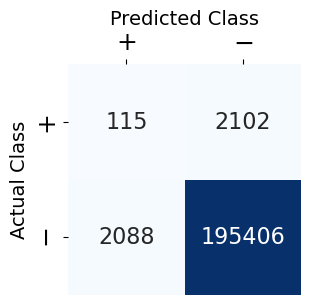

In [13]:
plot_confusion_matrix(rnd_forest_cmtx)
plt.show()

In [66]:
mlp = MultilayerPerceptronClassifier(labelCol="fraud_bool", layers=(35, 10, 2),
                                     maxIter=1000, stepSize=0.01,
                                     solver='l-bfgs', seed=42)
mlp_model = mlp.fit(train_os)

In [67]:
mlp_summary = mlp_model.evaluate(test)
mlp_cmtx = confusion_matrix(mlp_summary.predictions)

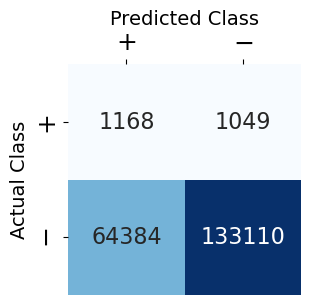

In [68]:
plot_confusion_matrix(mlp_cmtx)
plt.show()

In [69]:
evaluate_classifier(mlp_summary)

measure             value
0             fMeasureByLabel  [0.8027, 0.0345]
1            weightedFMeasure            0.7942
2                    accuracy            0.6724
3            precisionByLabel  [0.9922, 0.0178]
4               recallByLabel   [0.674, 0.5268]
5           weightedPrecision            0.9814
6              weightedRecall            0.6724
7     truePositiveRateByLabel   [0.674, 0.5268]
8    falsePositiveRateByLabel   [0.4732, 0.326]
9    weightedTruePositiveRate            0.6724
10  weightedFalsePositiveRate            0.4715

## Classification intra-clusters

Let's train a model for each of the clusters found during the classification analysis. Each model is then evaluated on the corrisponding cluster in the test set.

In [19]:
train = spark.read.option("header", True).parquet("train_features_selected")
test = spark.read.option("header", True).parquet("test_features_selected")

In [25]:
train.schema["features"].metadata

{'ml_attr': {'attrs': {'numeric': [{'idx': 0,
     'name': 'numerical_binary_ohe_vars_scaled_0'},
    {'idx': 1, 'name': 'numerical_binary_ohe_vars_scaled_1'},
    {'idx': 2, 'name': 'numerical_binary_ohe_vars_scaled_2'},
    {'idx': 3, 'name': 'numerical_binary_ohe_vars_scaled_3'},
    {'idx': 4, 'name': 'numerical_binary_ohe_vars_scaled_4'},
    {'idx': 5, 'name': 'numerical_binary_ohe_vars_scaled_5'},
    {'idx': 6, 'name': 'numerical_binary_ohe_vars_scaled_6'},
    {'idx': 7, 'name': 'numerical_binary_ohe_vars_scaled_7'},
    {'idx': 8, 'name': 'numerical_binary_ohe_vars_scaled_8'},
    {'idx': 9, 'name': 'numerical_binary_ohe_vars_scaled_9'},
    {'idx': 10, 'name': 'numerical_binary_ohe_vars_scaled_10'},
    {'idx': 11, 'name': 'numerical_binary_ohe_vars_scaled_11'},
    {'idx': 12, 'name': 'numerical_binary_ohe_vars_scaled_12'},
    {'idx': 13, 'name': 'numerical_binary_ohe_vars_scaled_13'},
    {'idx': 14, 'name': 'numerical_binary_ohe_vars_scaled_14'},
    {'idx': 15, 'name': 

In [21]:
# The "feature" vector already contains the cluster 
# labels, thus we need to remove it

slicer = VectorSlicer(inputCol="features", outputCol="features0", 
                      indices=list(range(34)))

train = slicer.transform(train).select("fraud_bool", "claster_label", "features0")
test = slicer.transform(test).select("fraud_bool", "claster_label", "features0")

In [22]:
train = train.withColumnRenamed("features0", "features")
test = test.withColumnRenamed("features0", "features")

In [13]:
train.printSchema()

root
 |-- fraud_bool: integer (nullable = true)
 |-- claster_label: integer (nullable = true)
 |-- features: vector (nullable = true)



In [13]:
# Train and test separate random forests within each cluster

n_clusters = 6
summaries = []

for cluster_label in range(n_clusters):
    training = train.filter(f"claster_label = {cluster_label}")
    testing = test.filter(f"claster_label = {cluster_label}")
    rnd_forest = RandomForestClassifier(labelCol="fraud_bool", numTrees=150,
                                        maxDepth=15, seed=42)
    rnd_forest_model = rnd_forest.fit(training)
    summary = rnd_forest_model.evaluate(testing)
    summaries.append(summary)

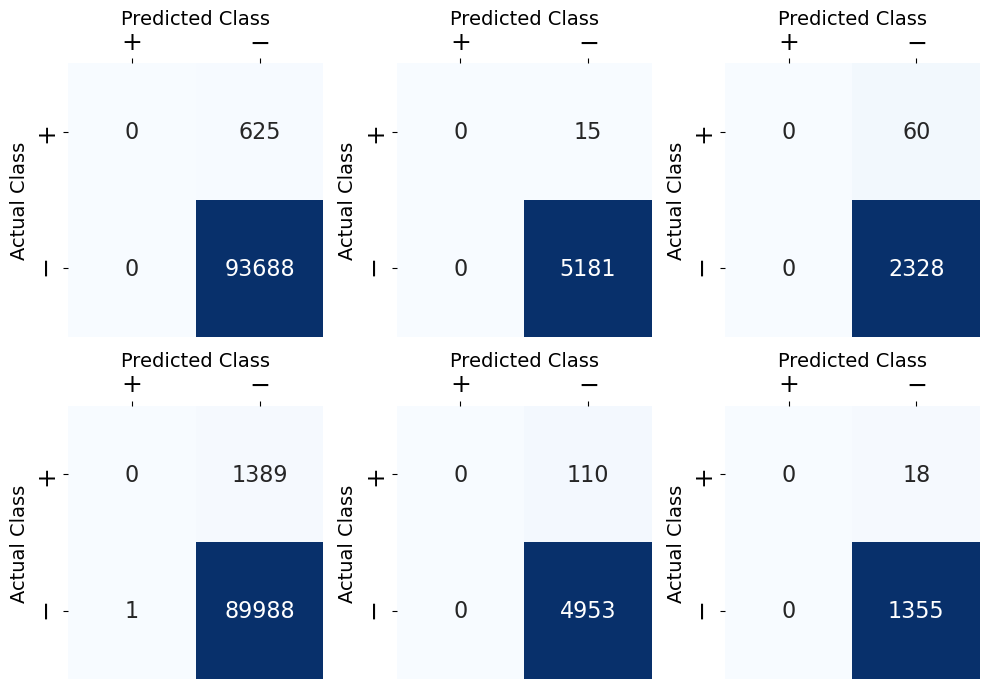

In [49]:
fig, axes = plt.subplots(2, 3, tight_layout=True, figsize=(10,7))
axes = np.ravel(axes)

for i, summary in enumerate(summaries):
    cm = confusion_matrix(summary.predictions)
    plot_confusion_matrix(cm, ax=axes[i])
    
plt.show()

In [26]:
# Train and test separate neuralnetworks within each cluster

n_clusters = 6
summaries = []

for cluster_label in range(n_clusters):
    training = train.filter(f"claster_label = {cluster_label}")
    testing = test.filter(f"claster_label = {cluster_label}")
    mlp = MultilayerPerceptronClassifier(labelCol="fraud_bool", 
                                         layers=(34, 10, 2),
                                         maxIter=1000, stepSize=0.01,
                                         solver='l-bfgs', seed=42)
    mlp_model = mlp.fit(training)
    summary = mlp_model.evaluate(testing)
    summaries.append(summary)

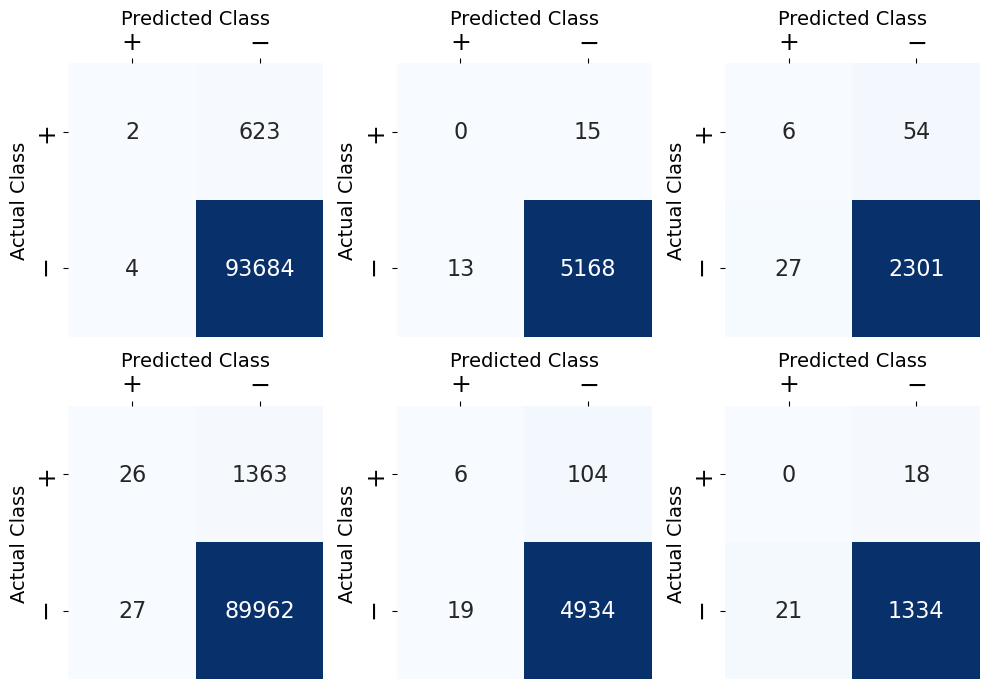

In [27]:
fig, axes = plt.subplots(2, 3, tight_layout=True, figsize=(10,7))
axes = np.ravel(axes)

for i, summary in enumerate(summaries):
    cm = confusion_matrix(summary.predictions)
    plot_confusion_matrix(cm, ax=axes[i])
    
plt.show()

In [40]:
stats = evaluate_classifier(summaries[0])
for i, summary in enumerate(summaries[1:], 1):
    stats = stats.merge(
        evaluate_classifier(summaries[i]), 
        how="outer", 
        on="measure",
        suffixes=(f"{i}", f"{i+1}")  # dummy suffixes
    )

stats.columns = ["measure"] + [f"cluster_{i}" for i in range(1,7)]
stats

measure         cluster_1      cluster_2  \
0             fMeasureByLabel  [0.9967, 0.0063]  [0.9973, 0.0]   
1            weightedFMeasure            0.9901         0.9944   
2                    accuracy            0.9934         0.9946   
3            precisionByLabel  [0.9934, 0.3333]  [0.9971, 0.0]   
4               recallByLabel     [1.0, 0.0032]  [0.9975, 0.0]   
5           weightedPrecision             0.989         0.9942   
6              weightedRecall            0.9934         0.9946   
7     truePositiveRateByLabel     [1.0, 0.0032]  [0.9975, 0.0]   
8    falsePositiveRateByLabel     [0.9968, 0.0]  [1.0, 0.0025]   
9    weightedTruePositiveRate            0.9934         0.9946   
10  weightedFalsePositiveRate            0.9902         0.9971   

           cluster_3         cluster_4         cluster_5      cluster_6  
0    [0.9827, 0.129]  [0.9923, 0.0361]  [0.9877, 0.0889]  [0.9856, 0.0]  
1             0.9613            0.9778            0.9682         0.9727  
2             0.9661            0.9848            0.9757         0.9716  
3   [0.9771, 0.1818]  [0.9851, 0.4906]    [0.9794, 0.24]  [0.9867, 0.0]  
4      [0.9884, 0.1]  [0.9997, 0.0187]  [0.9962, 0.0545]  [0.9845, 0.0]  
5             0.9571            0.9776            0.9633         0.9738  
6             0.9661            0.9848            0.9757         0.9716  
7      [0.9884, 0.1]  [0.9997, 0.0187]  [0.9962, 0.0545]  [0.9845, 0.0]  
8      [0.9, 0.0116]  [0.9813, 0.0003]  [0.9455, 0.0038]  [1.0, 0.0155]  
9             0.9661            0.9848            0.9757         0.9716  
10            0.8777            0.9664             0.925         0.9871